In [1]:
from cqtUnet import *
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
# from dataloader import *
from fulldataloader import *
from evaluate import *
from sklearn.model_selection import train_test_split
import pickle
import os
import matplotlib.pyplot as plt

# Training

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetPianoRoll(dropout_rate=0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [3]:

dataset = GuitarSetDataset()


# Check if the test set is already saved
test_samples_path = "test_samples.pkl"

if os.path.exists(test_samples_path):

    # Load the previously saved test samples
    with open(test_samples_path, "rb") as f:
        test_samples = pickle.load(f)
    
    # Define train_samples as the remaining samples
    train_samples = [s for s in dataset.samples if s not in test_samples]
    print('Test dataset loaded successfully')

else:

    # Split the dataset and save the test set for future use
    train_samples, test_samples = train_test_split(dataset.samples, test_size=0.2, random_state=42)
    
    with open(test_samples_path, "wb") as f:
        pickle.dump(test_samples, f)
    print('Test dataset created successfully')


# Initialize datasets
train_dataset = GuitarSetDataset(apply_nmf=False, apply_sections=True)
train_dataset.samples = train_samples

test_sections_dataset = GuitarSetDataset(apply_nmf=False, apply_sections=True)
test_sections_dataset.samples = test_samples

test_fullroll_dataset = GuitarSetDataset(apply_nmf=False, apply_sections=False)
test_fullroll_dataset.samples = test_samples

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=True, num_workers=8, 
    pin_memory=True, persistent_workers=True, prefetch_factor=8
)
test_apply_sections_loader = torch.utils.data.DataLoader(test_sections_dataset, batch_size=1, shuffle=False)
test_no_sections_loader = torch.utils.data.DataLoader(test_fullroll_dataset, batch_size=1, shuffle=False)

Test dataset loaded successfully


In [4]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        """
        Combines BCE and MSE loss.
        alpha: Weighting factor for BCE (0.5 means equal importance for BCE and MSE).
        """
        super(CombinedLoss, self).__init__()
        self.bce = nn.BCELoss() 
        self.mse = nn.MSELoss()
        self.alpha = alpha

    def forward(self, output, target):
        bce_loss = self.bce(output, target)
        mse_loss = self.mse(output, target)
        return self.alpha * bce_loss + (1 - self.alpha) * mse_loss

criterion = CombinedLoss(alpha=0.5)
criterion = criterion.to(device)

In [6]:
def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set model to training mode
    best_loss = float('inf')  # Track the best (lowest) loss
    losses = []  # List to store loss for each epoch
    first_last_losses = [] # Stores loss from first and last batch of each epoch

    for epoch in range(num_epochs):
        running_loss = 0.0
        losses_per_batch = []

        first_batch_loss = None
        last_batch_loss = None

        # Wrap the train_loader with tqdm for progress bar
        with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}/{num_epochs}") as tepoch:
            
            for batch_idx, (cqt_sections, piano_roll_sections, num_time_bins) in enumerate(tepoch):

                # Remove the first dimension (batch size = 1) and flatten sections into a true batch
                cqt_sections = cqt_sections.squeeze(0)  # Shape: (num_sections, 1, 156, 86)
                piano_roll_sections = piano_roll_sections.squeeze(0)  # Shape: (num_sections, 53, 86)

                # Move to GPU if available
                if torch.cuda.is_available():
                    cqt_sections = cqt_sections.cuda()
                    piano_roll_sections = piano_roll_sections.cuda()

                # Zero gradients
                optimizer.zero_grad()
                
                batch_loss = 0.0
                
                #iterate over sections
                for i in range (cqt_sections.shape[0]):
                    cqt_section = cqt_sections[i].unsqueeze(0)  # Shape: (1, 1, 156, 86)
                    piano_roll_section = piano_roll_sections[i].unsqueeze(0)  # Shape: (1, 53, 86)

                    # Forward pass
                    output = model(cqt_section)

                    # Ensure shapes match for loss calculation
                    assert output.shape == piano_roll_section.shape, \
                        f"Output shape {output.shape} != Target shape {piano_roll_section.shape}"

                    # Compute loss
                    loss = criterion(output, piano_roll_section)
                    
                    # Accumulate loss for this batch
                    batch_loss += loss.item()
                    losses_per_batch.append(loss.item())  # Store per-section loss

                    # Backward pass (for each section)
                    loss.backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
                optimizer.step()

                # Compute batch average loss
                batch_loss /= cqt_sections.shape[0]  # Normalize by number of sections
                running_loss += batch_loss

                # Store first and last batch losses
                if batch_idx == 0:
                    first_batch_loss = batch_loss
                if batch_idx == len(tepoch) - 1:
                    last_batch_loss = batch_loss

                # Update tqdm progress bar
                tepoch.set_postfix(loss=running_loss / (batch_idx + 1))

            # Compute epoch loss
            epoch_loss = running_loss / len(tepoch)
            losses.append(epoch_loss)

            #Append first and last batch loss
            if first_batch_loss is not None and last_batch_loss is not None:
                first_last_losses.append((first_batch_loss, last_batch_loss))

            # Print epoch summary
            print(f"Epoch {epoch+1} average loss: {epoch_loss:.4f}")

            # Save model if the current loss improves
            if epoch_loss < best_loss:
                print(f"Saving model with loss {epoch_loss:.4f} (improved from {best_loss:.4f})")
                torch.save(model.state_dict(), f"models/model_epoch_{epoch+1}.pth")
                best_loss = epoch_loss

    return losses, first_last_losses

In [7]:
losses, first_last_losses = train(model, train_loader, criterion, optimizer, num_epochs=144)

Epoch 2/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 1 average loss: 0.1065
Saving model with loss 0.1065 (improved from inf)


Epoch 3/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 2 average loss: 0.0475
Saving model with loss 0.0475 (improved from 0.1065)


Epoch 4/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 3 average loss: 0.0270
Saving model with loss 0.0270 (improved from 0.0475)


Epoch 5/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 4 average loss: 0.0214
Saving model with loss 0.0214 (improved from 0.0270)


Epoch 6/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 5 average loss: 0.0192
Saving model with loss 0.0192 (improved from 0.0214)


Epoch 7/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 6 average loss: 0.0179
Saving model with loss 0.0179 (improved from 0.0192)


Epoch 8/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 7 average loss: 0.0170
Saving model with loss 0.0170 (improved from 0.0179)


Epoch 9/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 8 average loss: 0.0164
Saving model with loss 0.0164 (improved from 0.0170)


Epoch 10/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 9 average loss: 0.0159
Saving model with loss 0.0159 (improved from 0.0164)


Epoch 11/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 10 average loss: 0.0154
Saving model with loss 0.0154 (improved from 0.0159)


Epoch 12/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 11 average loss: 0.0151
Saving model with loss 0.0151 (improved from 0.0154)


Epoch 13/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 12 average loss: 0.0147
Saving model with loss 0.0147 (improved from 0.0151)


Epoch 14/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 13 average loss: 0.0144
Saving model with loss 0.0144 (improved from 0.0147)


Epoch 15/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 14 average loss: 0.0141
Saving model with loss 0.0141 (improved from 0.0144)


Epoch 15/144: 100%|██████████| 1152/1152 [09:00<00:00,  2.13batch/s, loss=0.0139]


Epoch 15 average loss: 0.0139
Saving model with loss 0.0139 (improved from 0.0141)


Epoch 17/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 16 average loss: 0.0137
Saving model with loss 0.0137 (improved from 0.0139)


Epoch 18/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 17 average loss: 0.0134
Saving model with loss 0.0134 (improved from 0.0137)


Epoch 19/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 18 average loss: 0.0133
Saving model with loss 0.0133 (improved from 0.0134)


Epoch 20/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 19 average loss: 0.0131
Saving model with loss 0.0131 (improved from 0.0133)


Epoch 21/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 20 average loss: 0.0129
Saving model with loss 0.0129 (improved from 0.0131)


Epoch 22/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 21 average loss: 0.0128
Saving model with loss 0.0128 (improved from 0.0129)


Epoch 23/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 22 average loss: 0.0126
Saving model with loss 0.0126 (improved from 0.0128)


Epoch 24/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 23 average loss: 0.0125
Saving model with loss 0.0125 (improved from 0.0126)


Epoch 25/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 24 average loss: 0.0123
Saving model with loss 0.0123 (improved from 0.0125)


Epoch 26/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 25 average loss: 0.0122
Saving model with loss 0.0122 (improved from 0.0123)


Epoch 27/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 26 average loss: 0.0121
Saving model with loss 0.0121 (improved from 0.0122)


Epoch 28/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 27 average loss: 0.0119
Saving model with loss 0.0119 (improved from 0.0121)


Epoch 29/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 28 average loss: 0.0118
Saving model with loss 0.0118 (improved from 0.0119)


Epoch 30/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 29 average loss: 0.0117
Saving model with loss 0.0117 (improved from 0.0118)


Epoch 31/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 30 average loss: 0.0116
Saving model with loss 0.0116 (improved from 0.0117)


Epoch 32/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 31 average loss: 0.0115
Saving model with loss 0.0115 (improved from 0.0116)


Epoch 33/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 32 average loss: 0.0114
Saving model with loss 0.0114 (improved from 0.0115)


Epoch 34/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 33 average loss: 0.0113
Saving model with loss 0.0113 (improved from 0.0114)


Epoch 35/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 34 average loss: 0.0112
Saving model with loss 0.0112 (improved from 0.0113)


Epoch 36/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 35 average loss: 0.0111
Saving model with loss 0.0111 (improved from 0.0112)


Epoch 37/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 36 average loss: 0.0110
Saving model with loss 0.0110 (improved from 0.0111)


Epoch 38/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 37 average loss: 0.0109
Saving model with loss 0.0109 (improved from 0.0110)


Epoch 39/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 38 average loss: 0.0108
Saving model with loss 0.0108 (improved from 0.0109)


Epoch 40/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 39 average loss: 0.0108
Saving model with loss 0.0108 (improved from 0.0108)


Epoch 41/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 40 average loss: 0.0107
Saving model with loss 0.0107 (improved from 0.0108)


Epoch 42/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 41 average loss: 0.0106
Saving model with loss 0.0106 (improved from 0.0107)


Epoch 43/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 42 average loss: 0.0105
Saving model with loss 0.0105 (improved from 0.0106)


Epoch 44/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 43 average loss: 0.0104
Saving model with loss 0.0104 (improved from 0.0105)


Epoch 45/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 44 average loss: 0.0104
Saving model with loss 0.0104 (improved from 0.0104)


Epoch 46/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 45 average loss: 0.0103
Saving model with loss 0.0103 (improved from 0.0104)


Epoch 47/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 46 average loss: 0.0102
Saving model with loss 0.0102 (improved from 0.0103)


Epoch 48/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 47 average loss: 0.0101
Saving model with loss 0.0101 (improved from 0.0102)


Epoch 49/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 48 average loss: 0.0101
Saving model with loss 0.0101 (improved from 0.0101)


Epoch 50/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 49 average loss: 0.0100
Saving model with loss 0.0100 (improved from 0.0101)


Epoch 51/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 50 average loss: 0.0099
Saving model with loss 0.0099 (improved from 0.0100)


Epoch 52/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 51 average loss: 0.0099
Saving model with loss 0.0099 (improved from 0.0099)


Epoch 53/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 52 average loss: 0.0098
Saving model with loss 0.0098 (improved from 0.0099)


Epoch 54/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 53 average loss: 0.0097
Saving model with loss 0.0097 (improved from 0.0098)


Epoch 55/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 54 average loss: 0.0097
Saving model with loss 0.0097 (improved from 0.0097)


Epoch 56/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 55 average loss: 0.0096
Saving model with loss 0.0096 (improved from 0.0097)


Epoch 57/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 56 average loss: 0.0096
Saving model with loss 0.0096 (improved from 0.0096)


Epoch 58/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 57 average loss: 0.0095
Saving model with loss 0.0095 (improved from 0.0096)


Epoch 59/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 58 average loss: 0.0095
Saving model with loss 0.0095 (improved from 0.0095)


Epoch 60/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 59 average loss: 0.0094
Saving model with loss 0.0094 (improved from 0.0095)


Epoch 61/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 60 average loss: 0.0094
Saving model with loss 0.0094 (improved from 0.0094)


Epoch 62/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 61 average loss: 0.0093
Saving model with loss 0.0093 (improved from 0.0094)


Epoch 63/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 62 average loss: 0.0092
Saving model with loss 0.0092 (improved from 0.0093)


Epoch 64/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 63 average loss: 0.0092
Saving model with loss 0.0092 (improved from 0.0092)


Epoch 65/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 64 average loss: 0.0092
Saving model with loss 0.0092 (improved from 0.0092)


Epoch 66/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 65 average loss: 0.0091
Saving model with loss 0.0091 (improved from 0.0092)


Epoch 67/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 66 average loss: 0.0091
Saving model with loss 0.0091 (improved from 0.0091)


Epoch 68/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 67 average loss: 0.0090
Saving model with loss 0.0090 (improved from 0.0091)


Epoch 69/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 68 average loss: 0.0089
Saving model with loss 0.0089 (improved from 0.0090)


Epoch 70/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 69 average loss: 0.0089
Saving model with loss 0.0089 (improved from 0.0089)


Epoch 71/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 70 average loss: 0.0088
Saving model with loss 0.0088 (improved from 0.0089)


Epoch 72/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 71 average loss: 0.0088
Saving model with loss 0.0088 (improved from 0.0088)


Epoch 73/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 72 average loss: 0.0088
Saving model with loss 0.0088 (improved from 0.0088)


Epoch 74/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 73 average loss: 0.0087
Saving model with loss 0.0087 (improved from 0.0088)


Epoch 75/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 74 average loss: 0.0087
Saving model with loss 0.0087 (improved from 0.0087)


Epoch 76/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 75 average loss: 0.0087
Saving model with loss 0.0087 (improved from 0.0087)


Epoch 77/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 76 average loss: 0.0086
Saving model with loss 0.0086 (improved from 0.0087)


Epoch 78/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 77 average loss: 0.0086
Saving model with loss 0.0086 (improved from 0.0086)


Epoch 79/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 78 average loss: 0.0085
Saving model with loss 0.0085 (improved from 0.0086)


Epoch 80/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 79 average loss: 0.0085
Saving model with loss 0.0085 (improved from 0.0085)


Epoch 81/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 80 average loss: 0.0084
Saving model with loss 0.0084 (improved from 0.0085)


Epoch 82/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 81 average loss: 0.0084
Saving model with loss 0.0084 (improved from 0.0084)


Epoch 83/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 82 average loss: 0.0084
Saving model with loss 0.0084 (improved from 0.0084)


Epoch 84/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 83 average loss: 0.0083
Saving model with loss 0.0083 (improved from 0.0084)


Epoch 85/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 84 average loss: 0.0083
Saving model with loss 0.0083 (improved from 0.0083)


Epoch 86/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 85 average loss: 0.0083
Saving model with loss 0.0083 (improved from 0.0083)


Epoch 87/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 86 average loss: 0.0082
Saving model with loss 0.0082 (improved from 0.0083)


Epoch 88/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 87 average loss: 0.0082
Saving model with loss 0.0082 (improved from 0.0082)


Epoch 89/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 88 average loss: 0.0081
Saving model with loss 0.0081 (improved from 0.0082)


Epoch 90/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 89 average loss: 0.0082


Epoch 91/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 90 average loss: 0.0081
Saving model with loss 0.0081 (improved from 0.0081)


Epoch 92/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 91 average loss: 0.0081
Saving model with loss 0.0081 (improved from 0.0081)


Epoch 93/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 92 average loss: 0.0080
Saving model with loss 0.0080 (improved from 0.0081)


Epoch 94/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 93 average loss: 0.0080
Saving model with loss 0.0080 (improved from 0.0080)


Epoch 95/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 94 average loss: 0.0080
Saving model with loss 0.0080 (improved from 0.0080)


Epoch 96/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 95 average loss: 0.0079
Saving model with loss 0.0079 (improved from 0.0080)


Epoch 97/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 96 average loss: 0.0079
Saving model with loss 0.0079 (improved from 0.0079)


Epoch 98/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 97 average loss: 0.0079
Saving model with loss 0.0079 (improved from 0.0079)


Epoch 99/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 98 average loss: 0.0078
Saving model with loss 0.0078 (improved from 0.0079)


Epoch 100/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 99 average loss: 0.0078


Epoch 101/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 100 average loss: 0.0078
Saving model with loss 0.0078 (improved from 0.0078)


Epoch 102/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 101 average loss: 0.0078
Saving model with loss 0.0078 (improved from 0.0078)


Epoch 103/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 102 average loss: 0.0077
Saving model with loss 0.0077 (improved from 0.0078)


Epoch 104/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 103 average loss: 0.0077
Saving model with loss 0.0077 (improved from 0.0077)


Epoch 105/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 104 average loss: 0.0077
Saving model with loss 0.0077 (improved from 0.0077)


Epoch 106/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 105 average loss: 0.0077
Saving model with loss 0.0077 (improved from 0.0077)


Epoch 107/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 106 average loss: 0.0076
Saving model with loss 0.0076 (improved from 0.0077)


Epoch 108/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 107 average loss: 0.0076
Saving model with loss 0.0076 (improved from 0.0076)


Epoch 109/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 108 average loss: 0.0076
Saving model with loss 0.0076 (improved from 0.0076)


Epoch 110/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 109 average loss: 0.0075
Saving model with loss 0.0075 (improved from 0.0076)


Epoch 111/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 110 average loss: 0.0075
Saving model with loss 0.0075 (improved from 0.0075)


Epoch 112/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 111 average loss: 0.0075
Saving model with loss 0.0075 (improved from 0.0075)


Epoch 113/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 112 average loss: 0.0075
Saving model with loss 0.0075 (improved from 0.0075)


Epoch 114/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 113 average loss: 0.0075
Saving model with loss 0.0075 (improved from 0.0075)


Epoch 114/144: 100%|██████████| 1152/1152 [09:09<00:00,  2.10batch/s, loss=0.00745]


Epoch 114 average loss: 0.0074
Saving model with loss 0.0074 (improved from 0.0075)


Epoch 116/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 115 average loss: 0.0074
Saving model with loss 0.0074 (improved from 0.0074)


Epoch 117/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 116 average loss: 0.0074
Saving model with loss 0.0074 (improved from 0.0074)


Epoch 118/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 117 average loss: 0.0074
Saving model with loss 0.0074 (improved from 0.0074)


Epoch 119/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 118 average loss: 0.0073
Saving model with loss 0.0073 (improved from 0.0074)


Epoch 120/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 119 average loss: 0.0073
Saving model with loss 0.0073 (improved from 0.0073)


Epoch 121/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 120 average loss: 0.0073
Saving model with loss 0.0073 (improved from 0.0073)


Epoch 122/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 121 average loss: 0.0073


Epoch 123/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 122 average loss: 0.0073
Saving model with loss 0.0073 (improved from 0.0073)


Epoch 124/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 123 average loss: 0.0072
Saving model with loss 0.0072 (improved from 0.0073)


Epoch 125/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 124 average loss: 0.0072
Saving model with loss 0.0072 (improved from 0.0072)


Epoch 126/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 125 average loss: 0.0072
Saving model with loss 0.0072 (improved from 0.0072)


Epoch 127/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 126 average loss: 0.0072
Saving model with loss 0.0072 (improved from 0.0072)


Epoch 128/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 127 average loss: 0.0072
Saving model with loss 0.0072 (improved from 0.0072)


Epoch 129/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 128 average loss: 0.0071
Saving model with loss 0.0071 (improved from 0.0072)


Epoch 130/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 129 average loss: 0.0071
Saving model with loss 0.0071 (improved from 0.0071)


Epoch 131/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 130 average loss: 0.0071
Saving model with loss 0.0071 (improved from 0.0071)


Epoch 132/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 131 average loss: 0.0071
Saving model with loss 0.0071 (improved from 0.0071)


Epoch 133/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 132 average loss: 0.0071
Saving model with loss 0.0071 (improved from 0.0071)


Epoch 134/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 133 average loss: 0.0071
Saving model with loss 0.0071 (improved from 0.0071)


Epoch 135/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 134 average loss: 0.0071
Saving model with loss 0.0071 (improved from 0.0071)


Epoch 136/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 135 average loss: 0.0070
Saving model with loss 0.0070 (improved from 0.0071)


Epoch 137/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 136 average loss: 0.0070
Saving model with loss 0.0070 (improved from 0.0070)


Epoch 138/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 137 average loss: 0.0070


Epoch 139/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 138 average loss: 0.0070
Saving model with loss 0.0070 (improved from 0.0070)


Epoch 140/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 139 average loss: 0.0070
Saving model with loss 0.0070 (improved from 0.0070)


Epoch 141/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 140 average loss: 0.0069
Saving model with loss 0.0069 (improved from 0.0070)


Epoch 142/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 141 average loss: 0.0069
Saving model with loss 0.0069 (improved from 0.0069)


Epoch 143/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 142 average loss: 0.0069
Saving model with loss 0.0069 (improved from 0.0069)


Epoch 144/144:   0%|          | 0/1152 [00:00<?, ?batch/s]

Epoch 143 average loss: 0.0069


Epoch 144/144: 100%|██████████| 1152/1152 [09:14<00:00,  2.08batch/s, loss=0.00688]

Epoch 144 average loss: 0.0069
Saving model with loss 0.0069 (improved from 0.0069)


In [12]:
plt.savefig('loss144.png')

<Figure size 432x288 with 0 Axes>

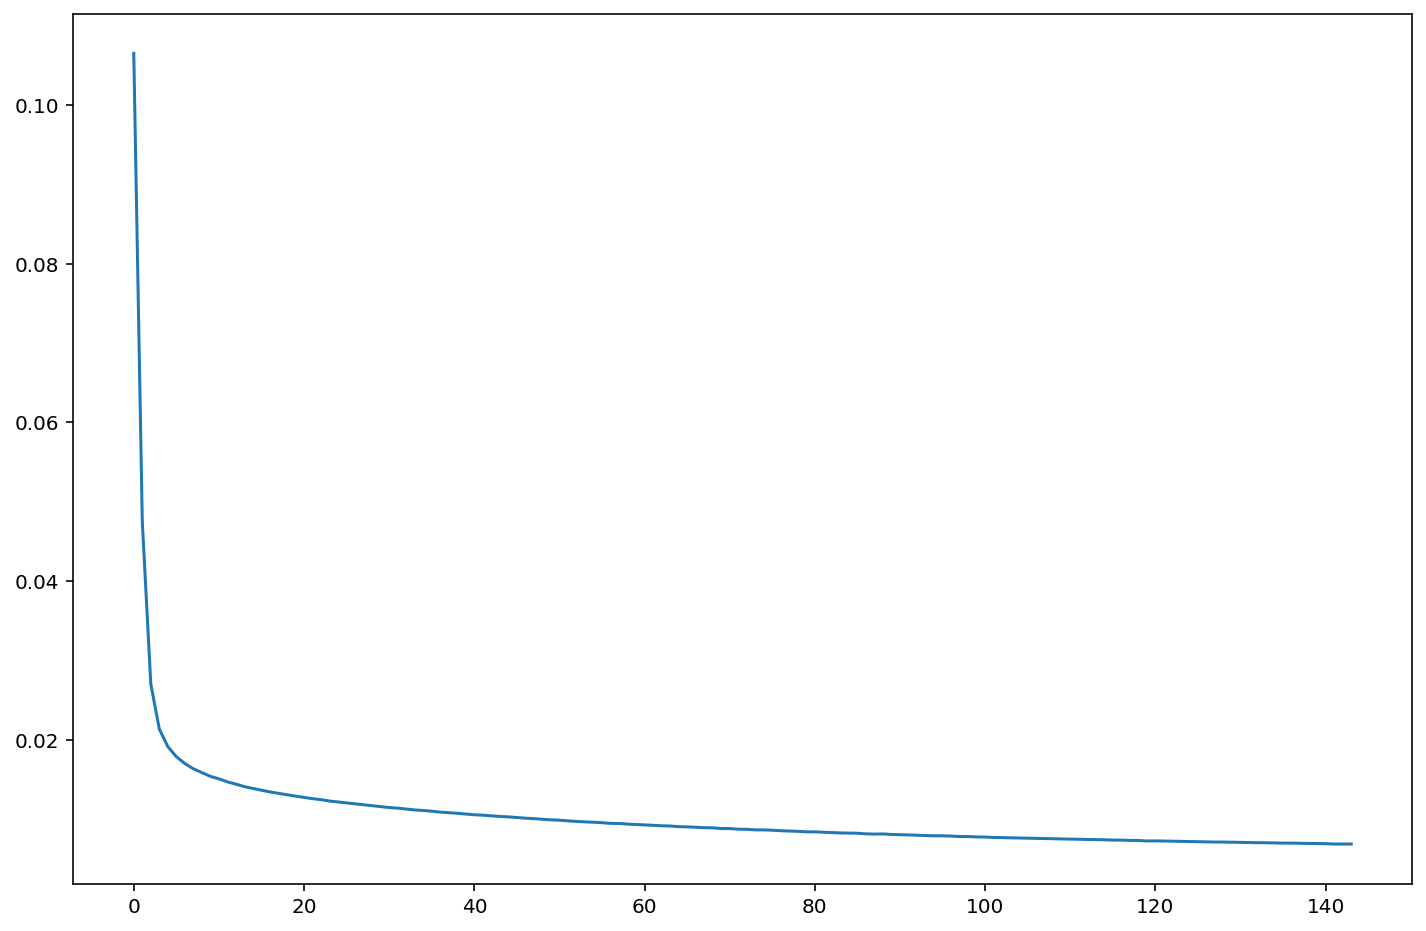

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(losses)

# Evaluation

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetPianoRoll().to(device) 
model.load_state_dict(torch.load("models/final144.pth", map_location=device))

/var/folders/g1/_jmd0tb55d58p50yyylwr0_00000gn/T/ipykernel_3532/3961961820.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/final

<All keys matched successfully>

In [8]:
predicted_piano_rolls, ground_truth_piano_rolls = inference(model, test_sections_dataset, apply_sections=True)

Inference Progress: 100%|██████████| 288/288 [06:40<00:00,  1.39s/it]


In [27]:
avg_prec, avg_rec, avg_f1 = get_metrics(predicted_piano_rolls, ground_truth_piano_rolls, threshold=0.11)
print(f"Average Precision: {avg_prec}")
print(f"Average Recall: {avg_rec}")
print(f"Average F1 Score: {avg_f1}")

Average Precision: 0.8243081143961368
Average Recall: 0.8213156363981756
Average F1 Score: 0.8060222865205146


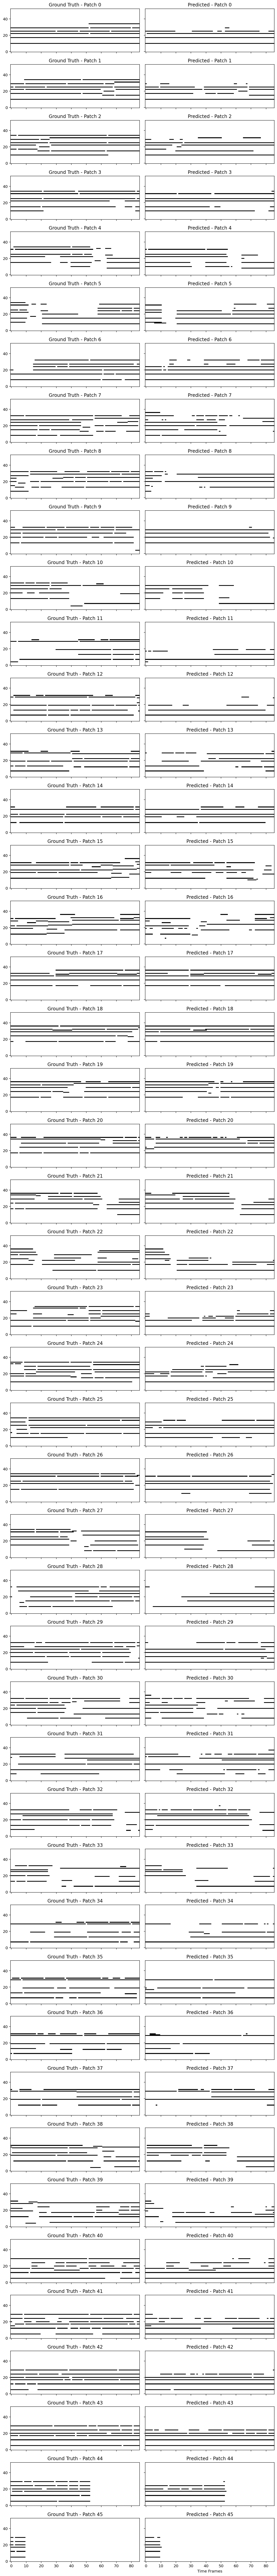

In [ ]:
plot_pianoroll_comparison(predicted_piano_rolls[0], ground_truth_piano_rolls[0], apply_sections=True, threshold=0.11)

In [28]:
predicted_piano_rolls, ground_truth_piano_rolls = inference(model, test_fullroll_dataset, apply_sections=False)

Inference Progress: 100%|██████████| 288/288 [05:05<00:00,  1.06s/it]


In [41]:
avg_prec, avg_rec, avg_f1 = get_metrics(predicted_piano_rolls, ground_truth_piano_rolls, threshold=0.15)
print(f"Average Precision: {avg_prec}")
print(f"Average Recall: {avg_rec}")
print(f"Average F1 Score: {avg_f1}")

Average Precision: 0.8472722359179272
Average Recall: 0.8247402405829913
Average F1 Score: 0.8271266970239997


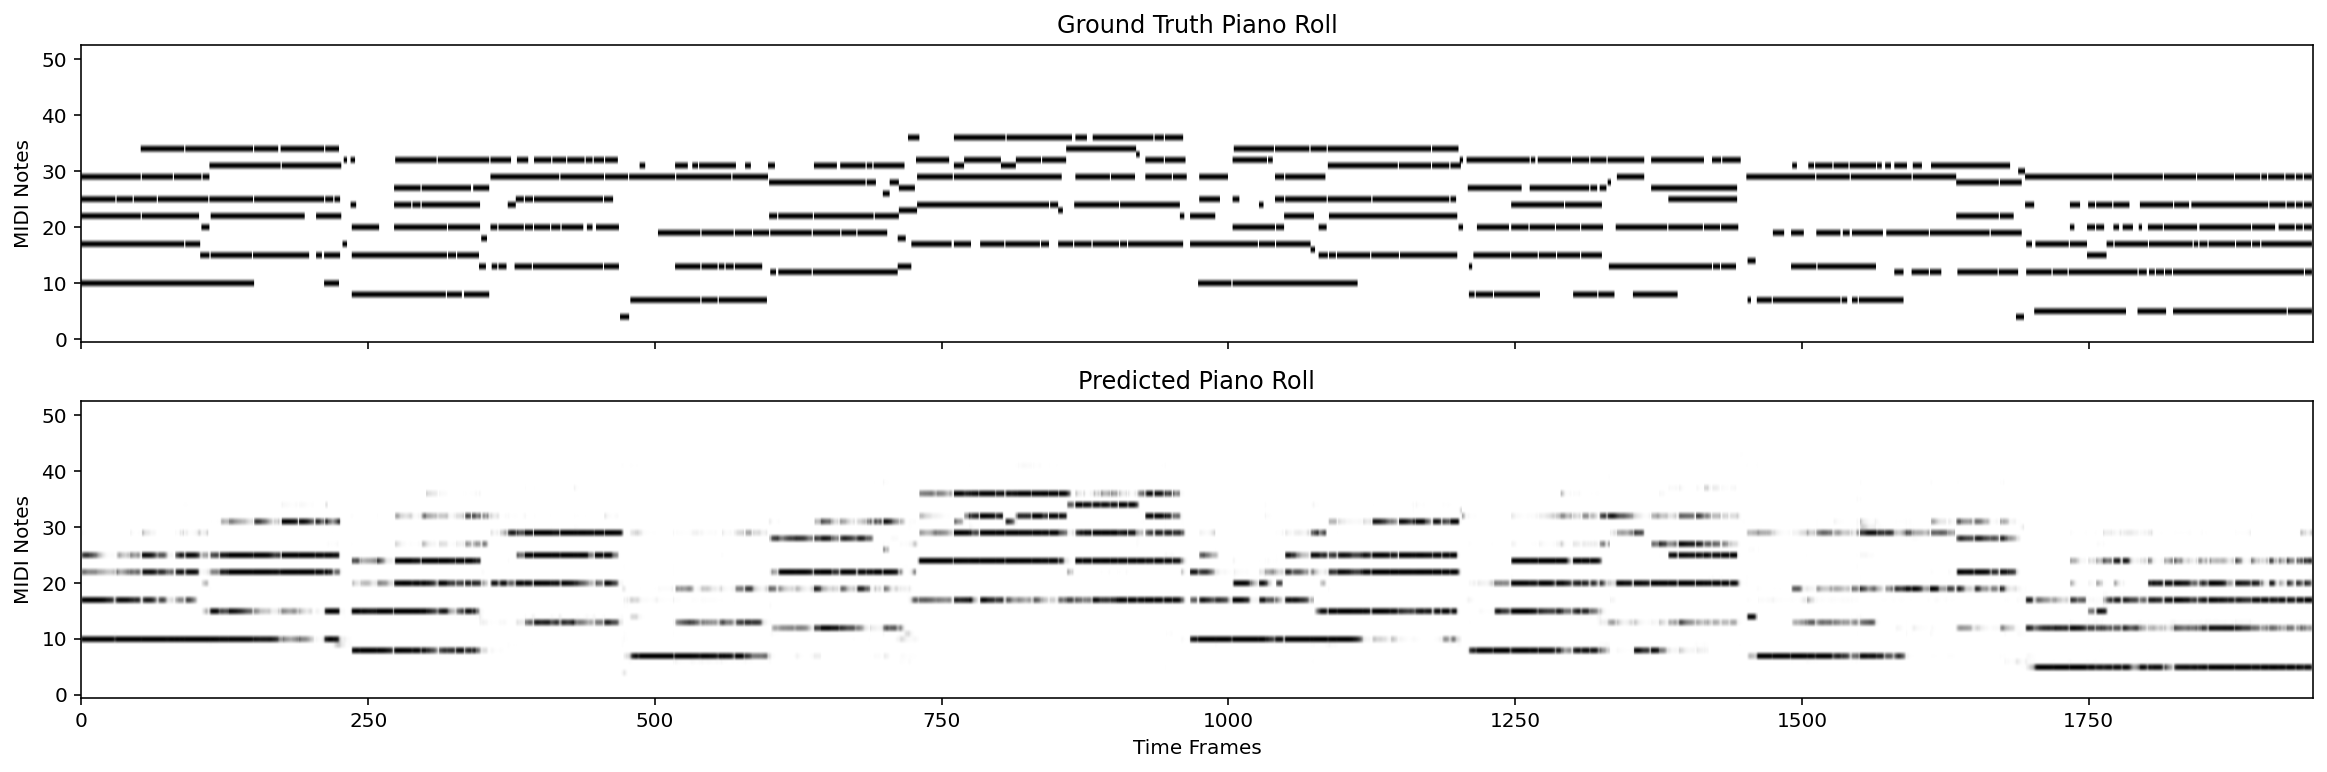

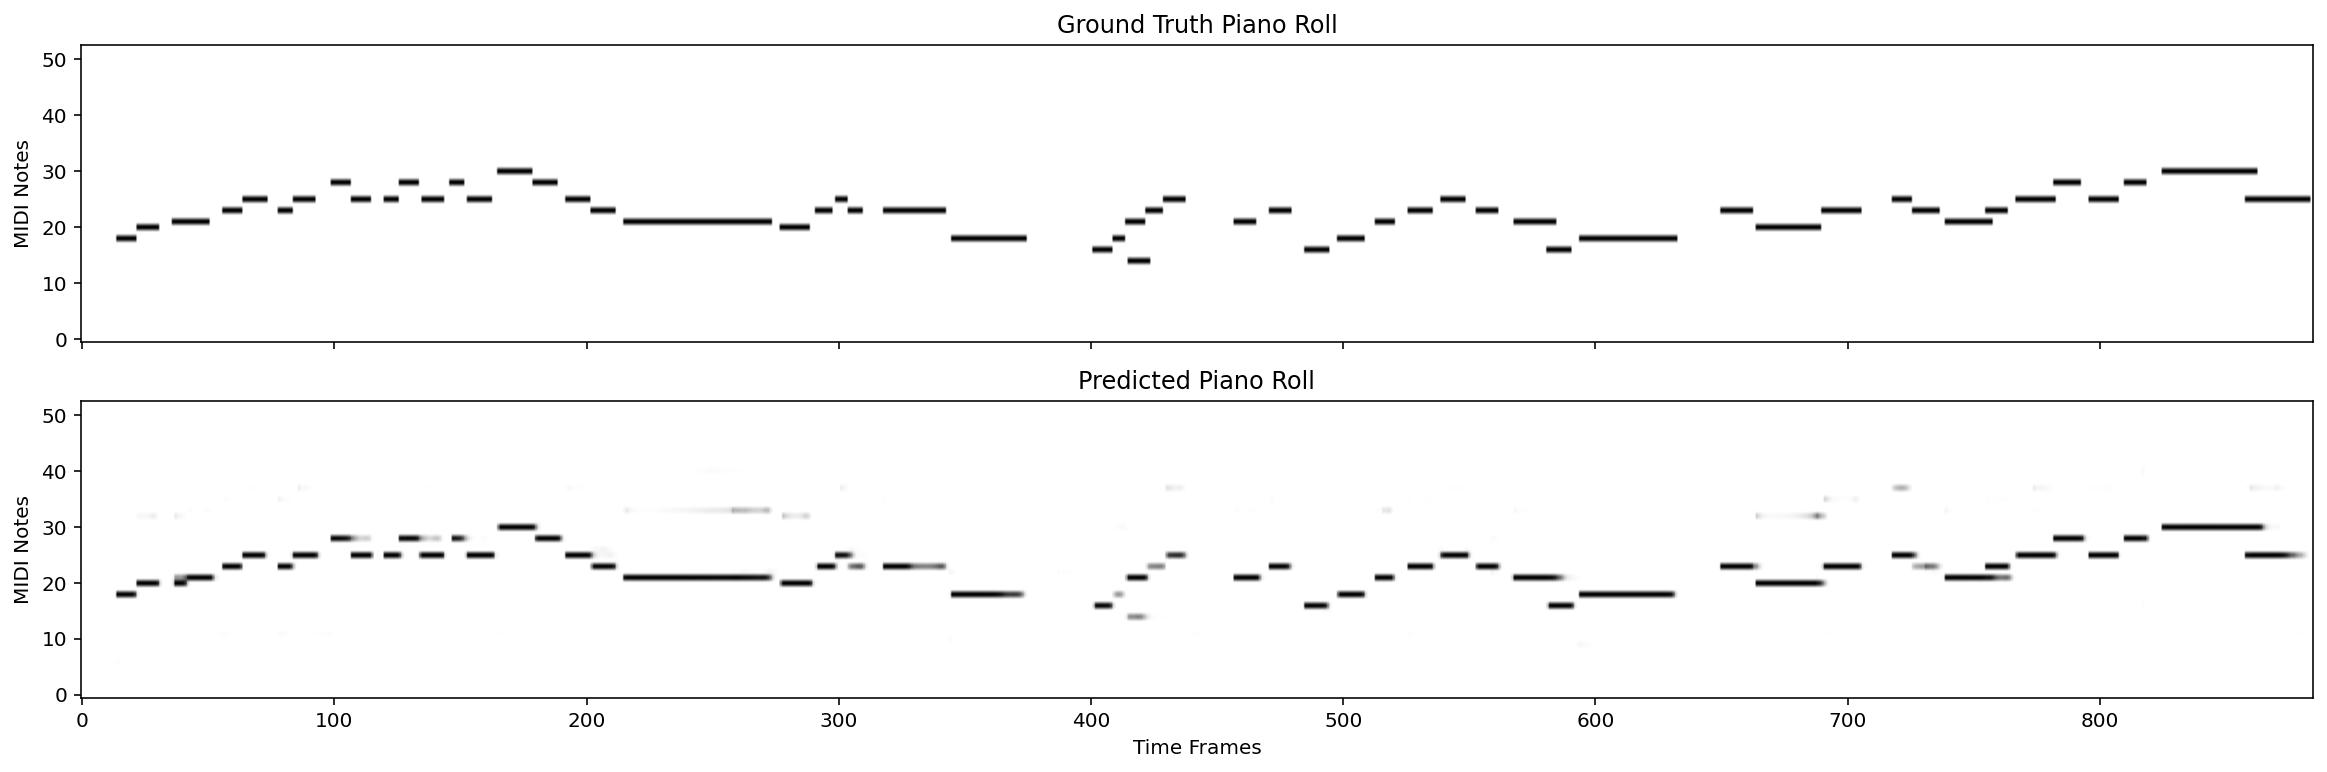

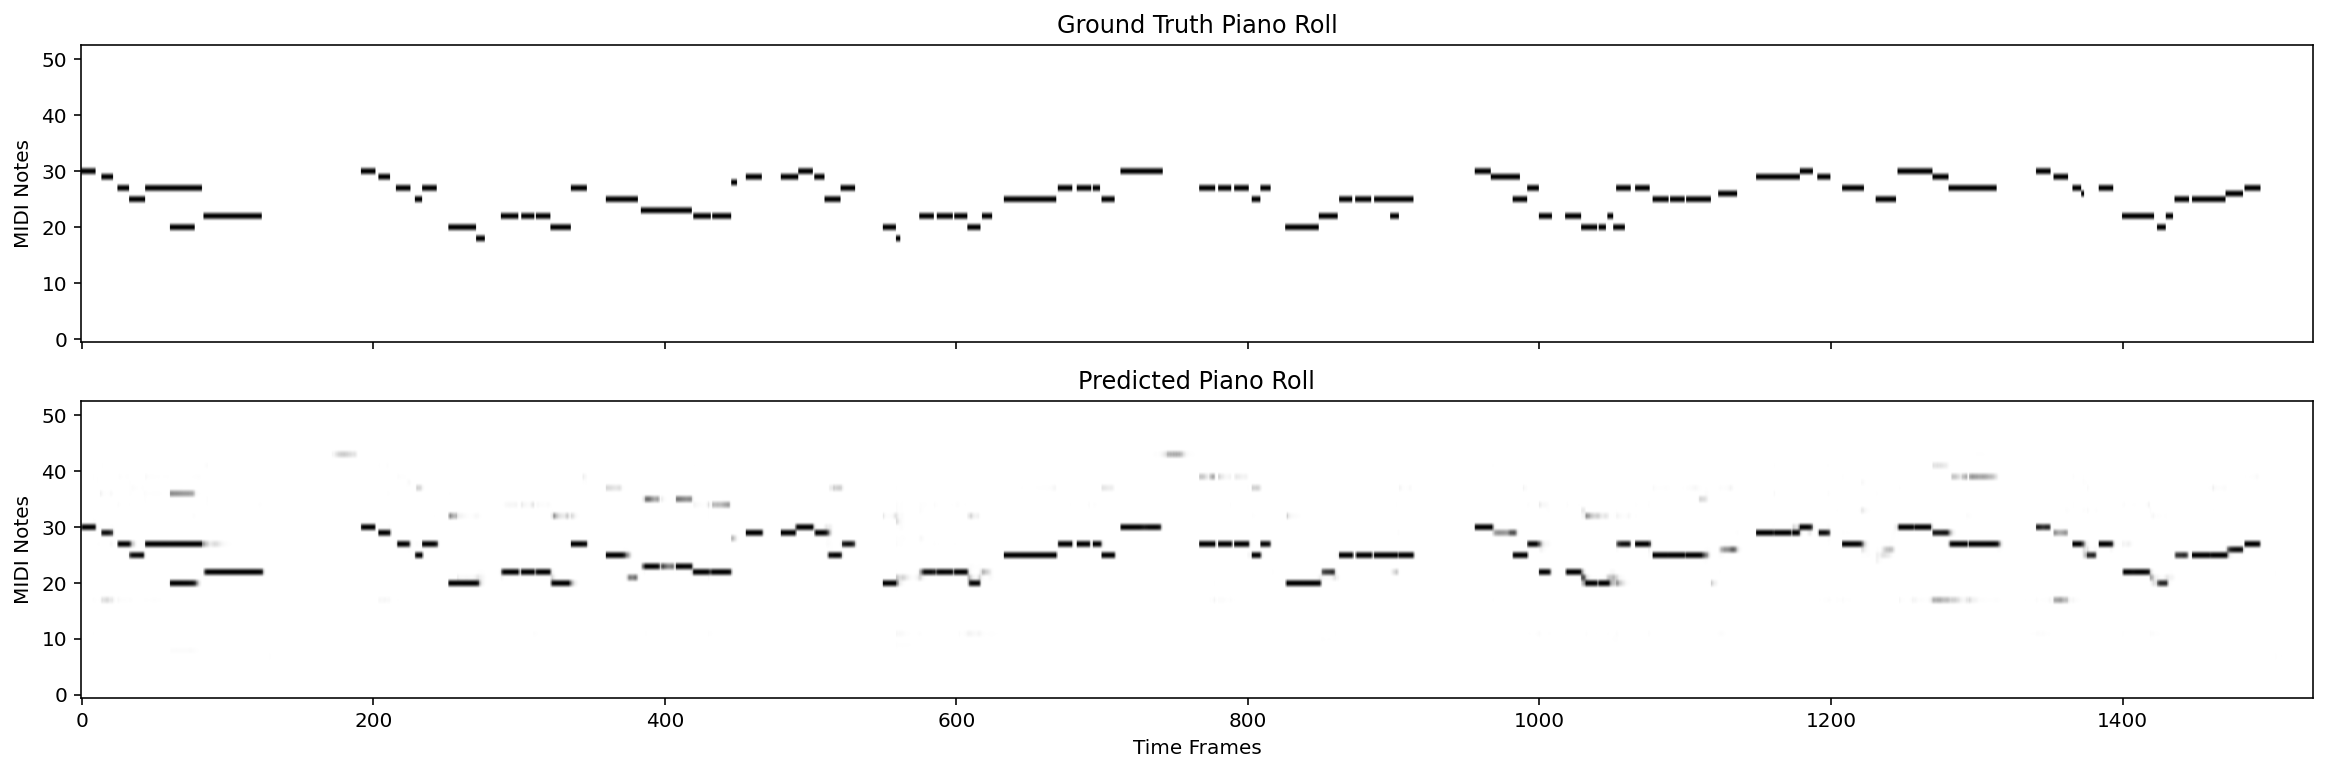

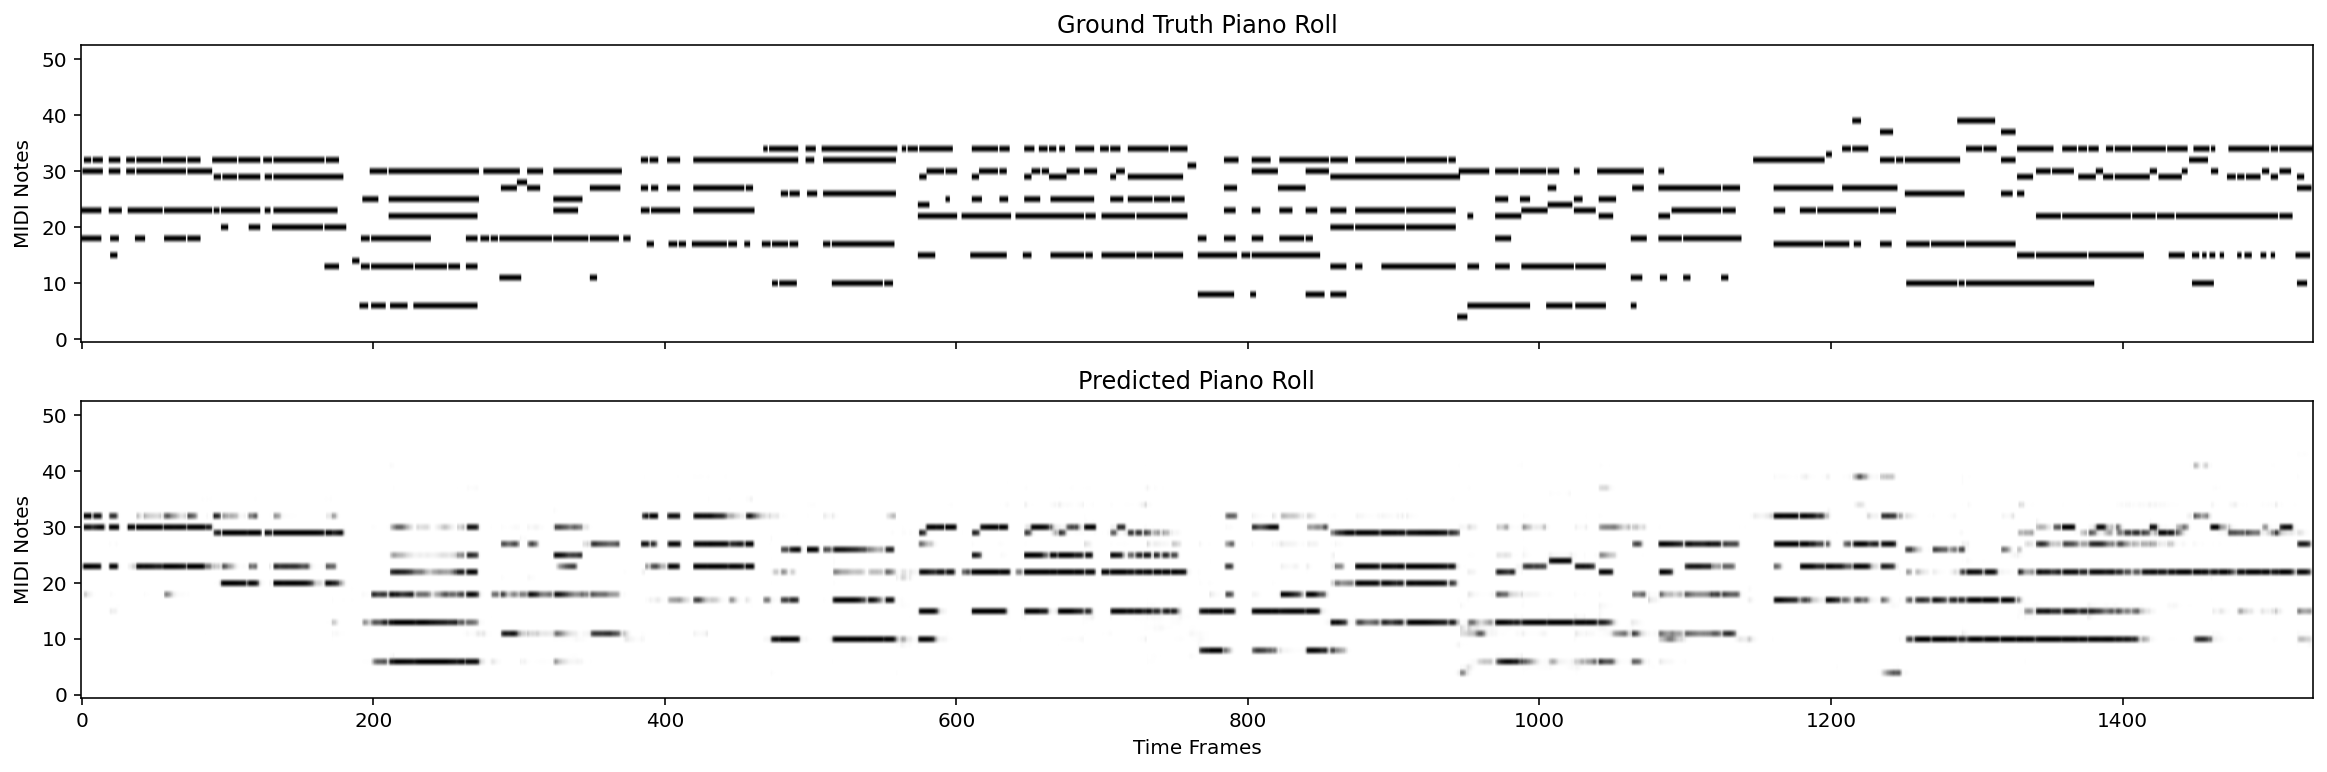

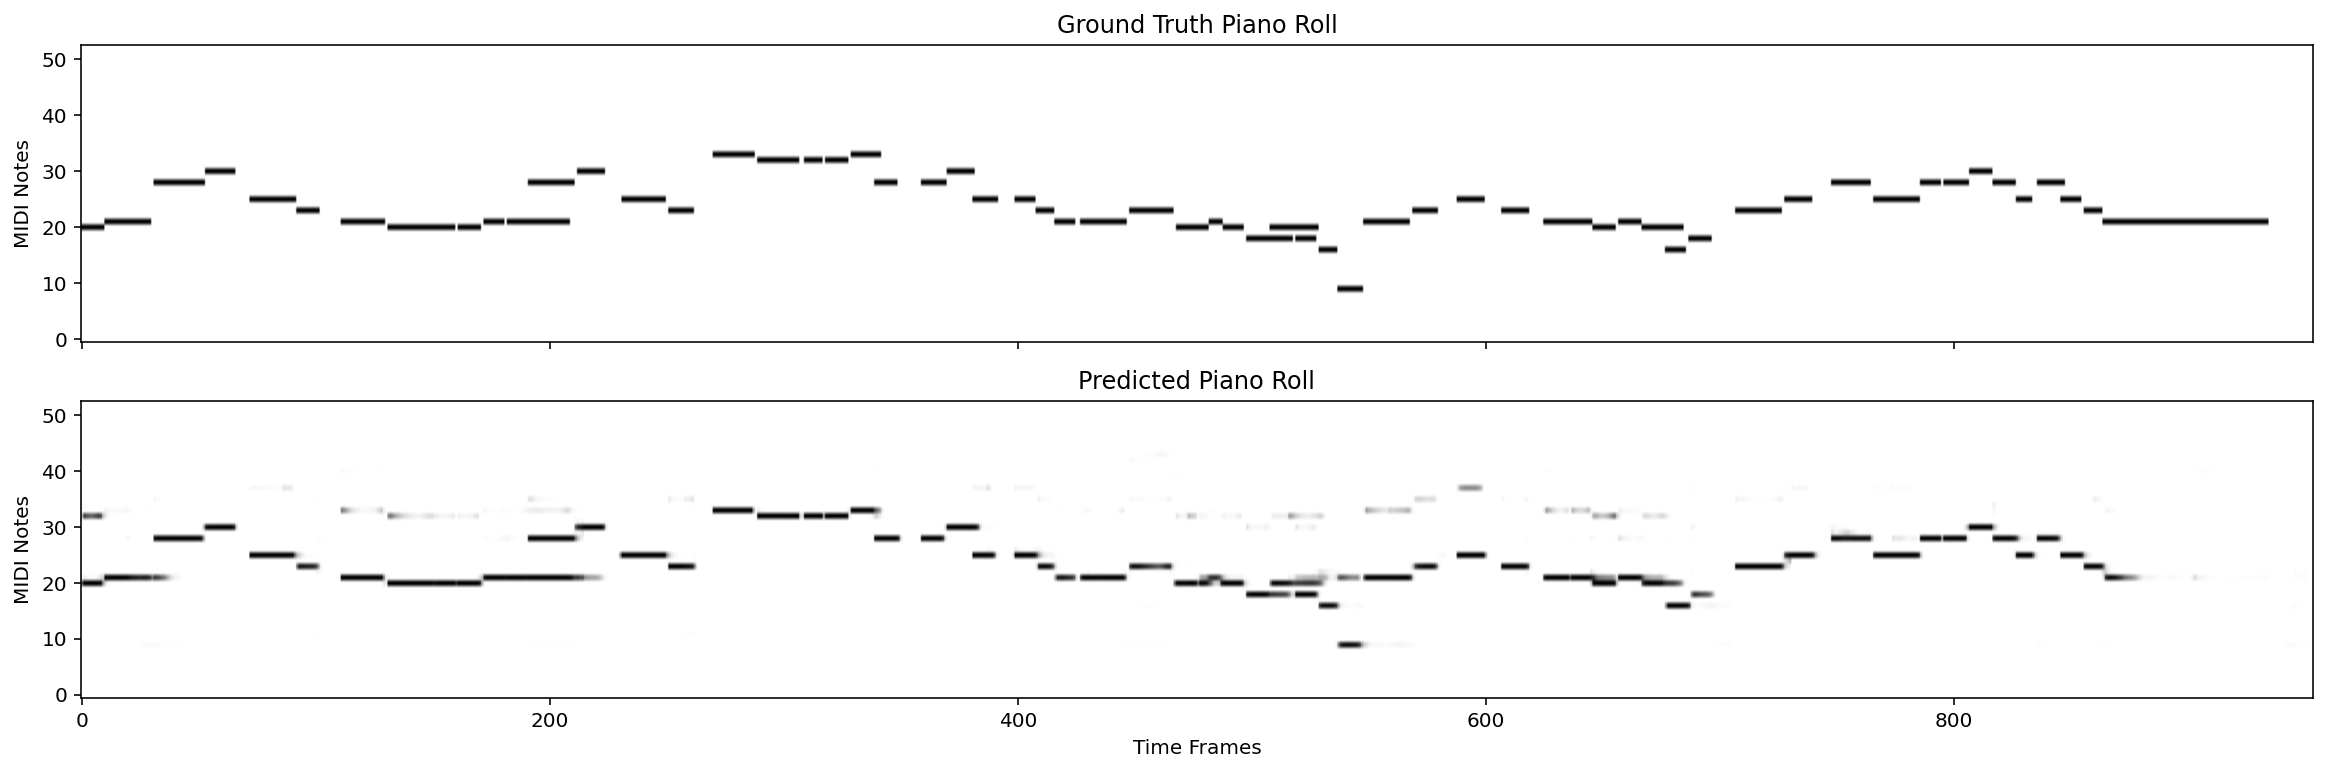

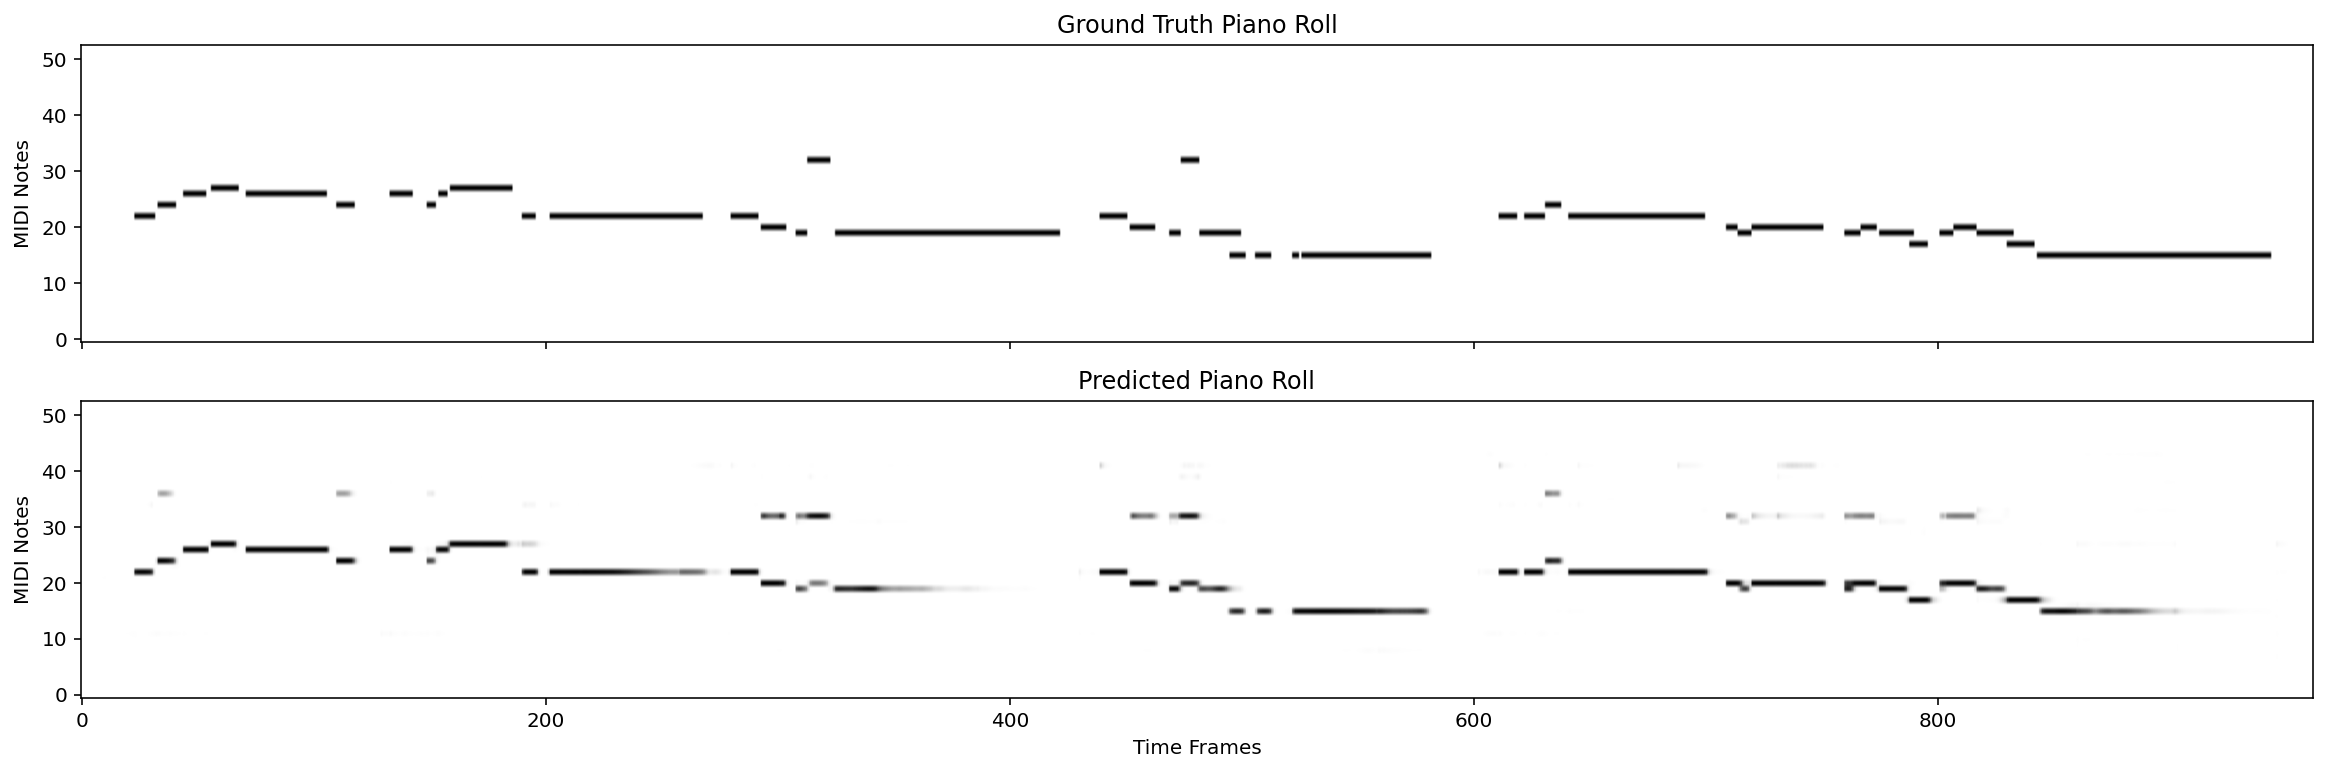

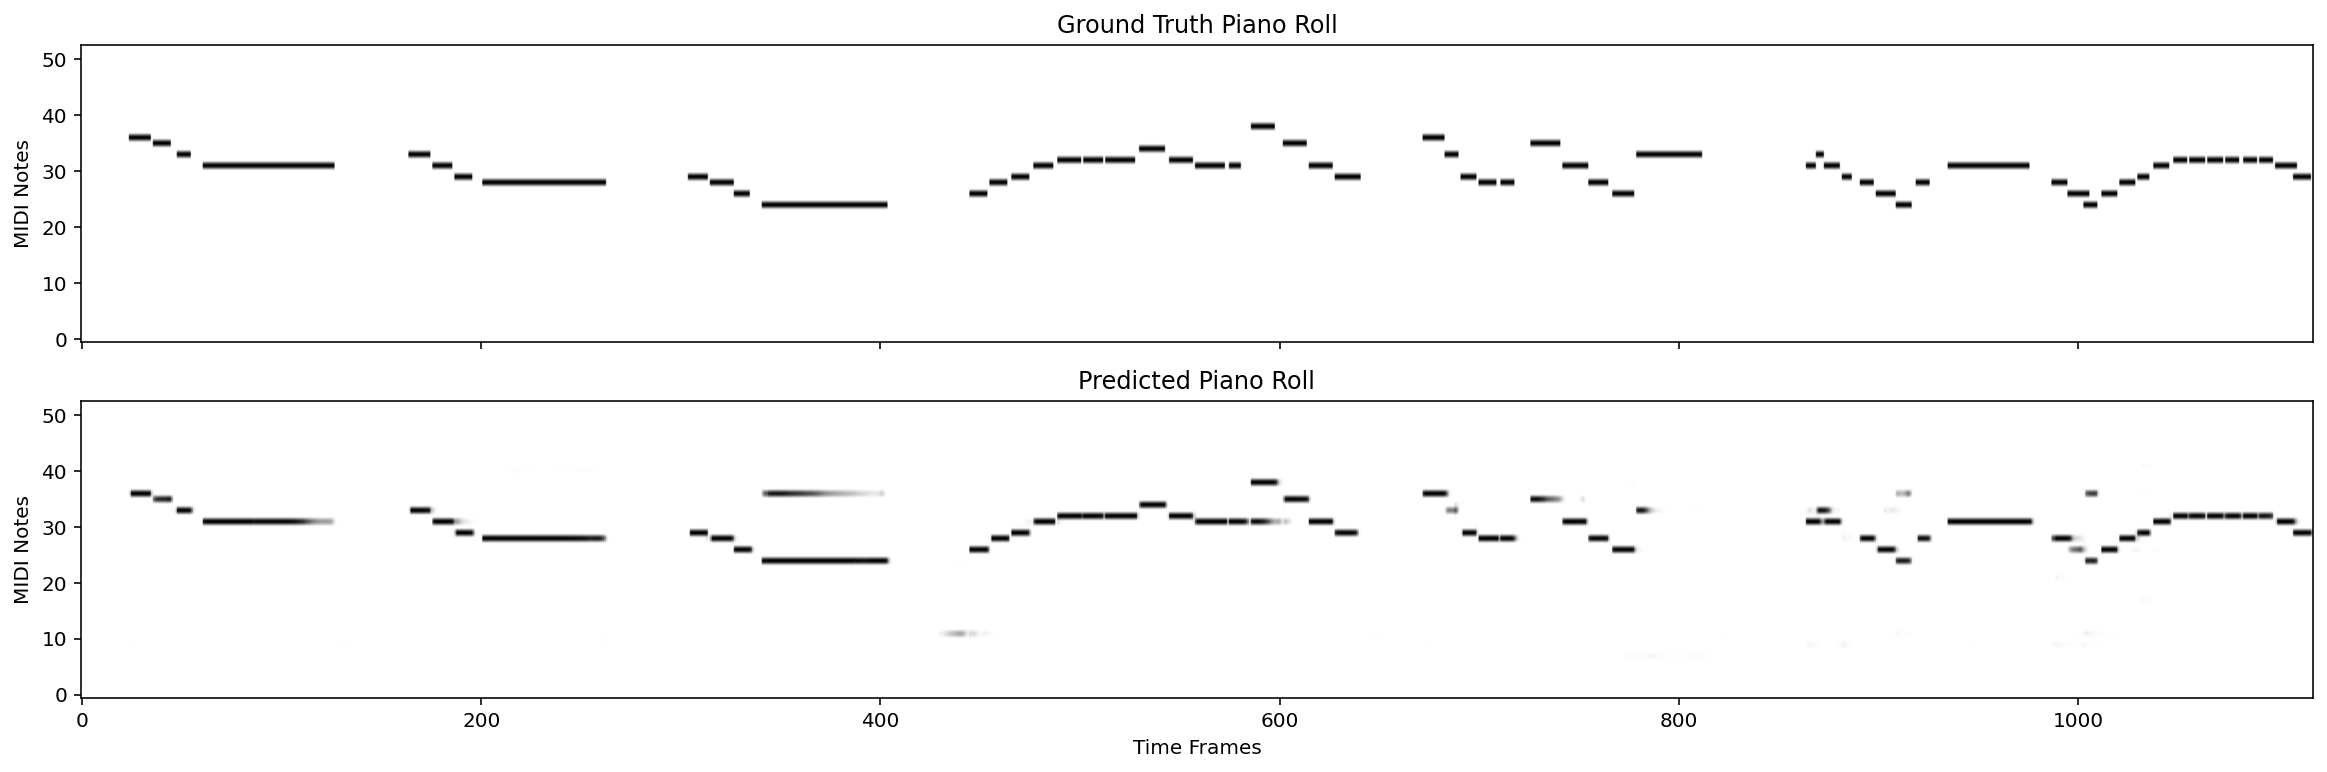

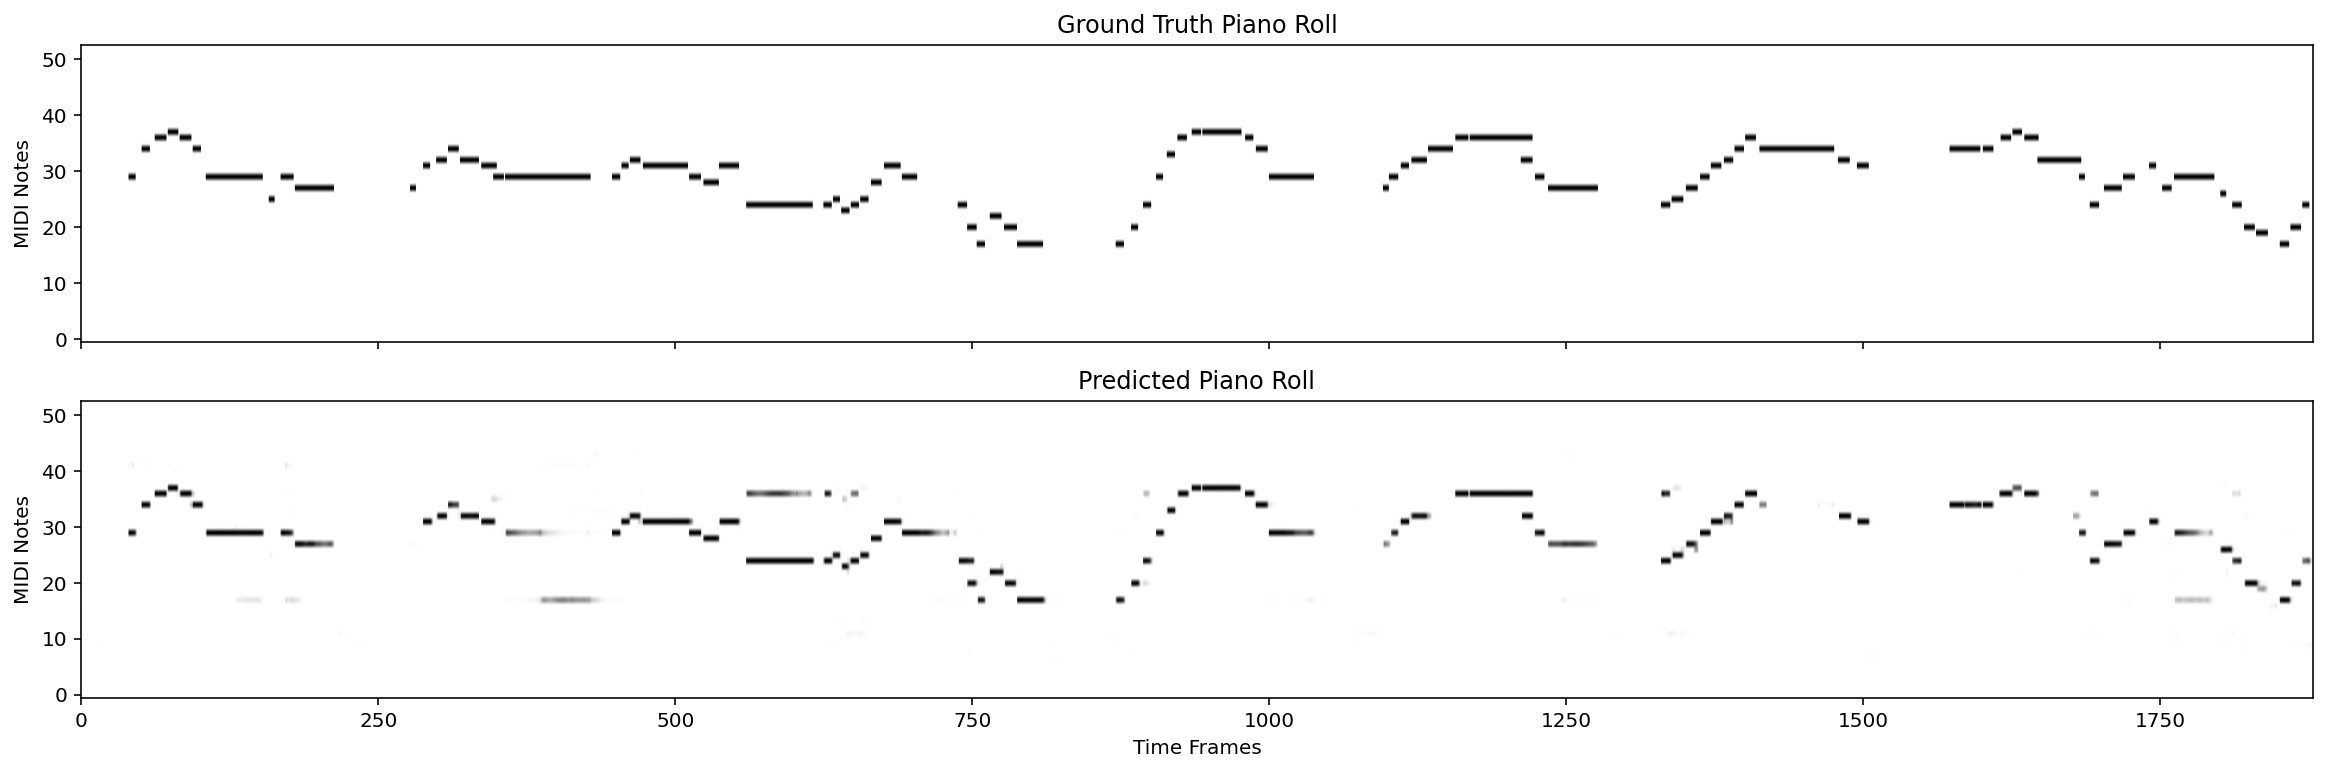

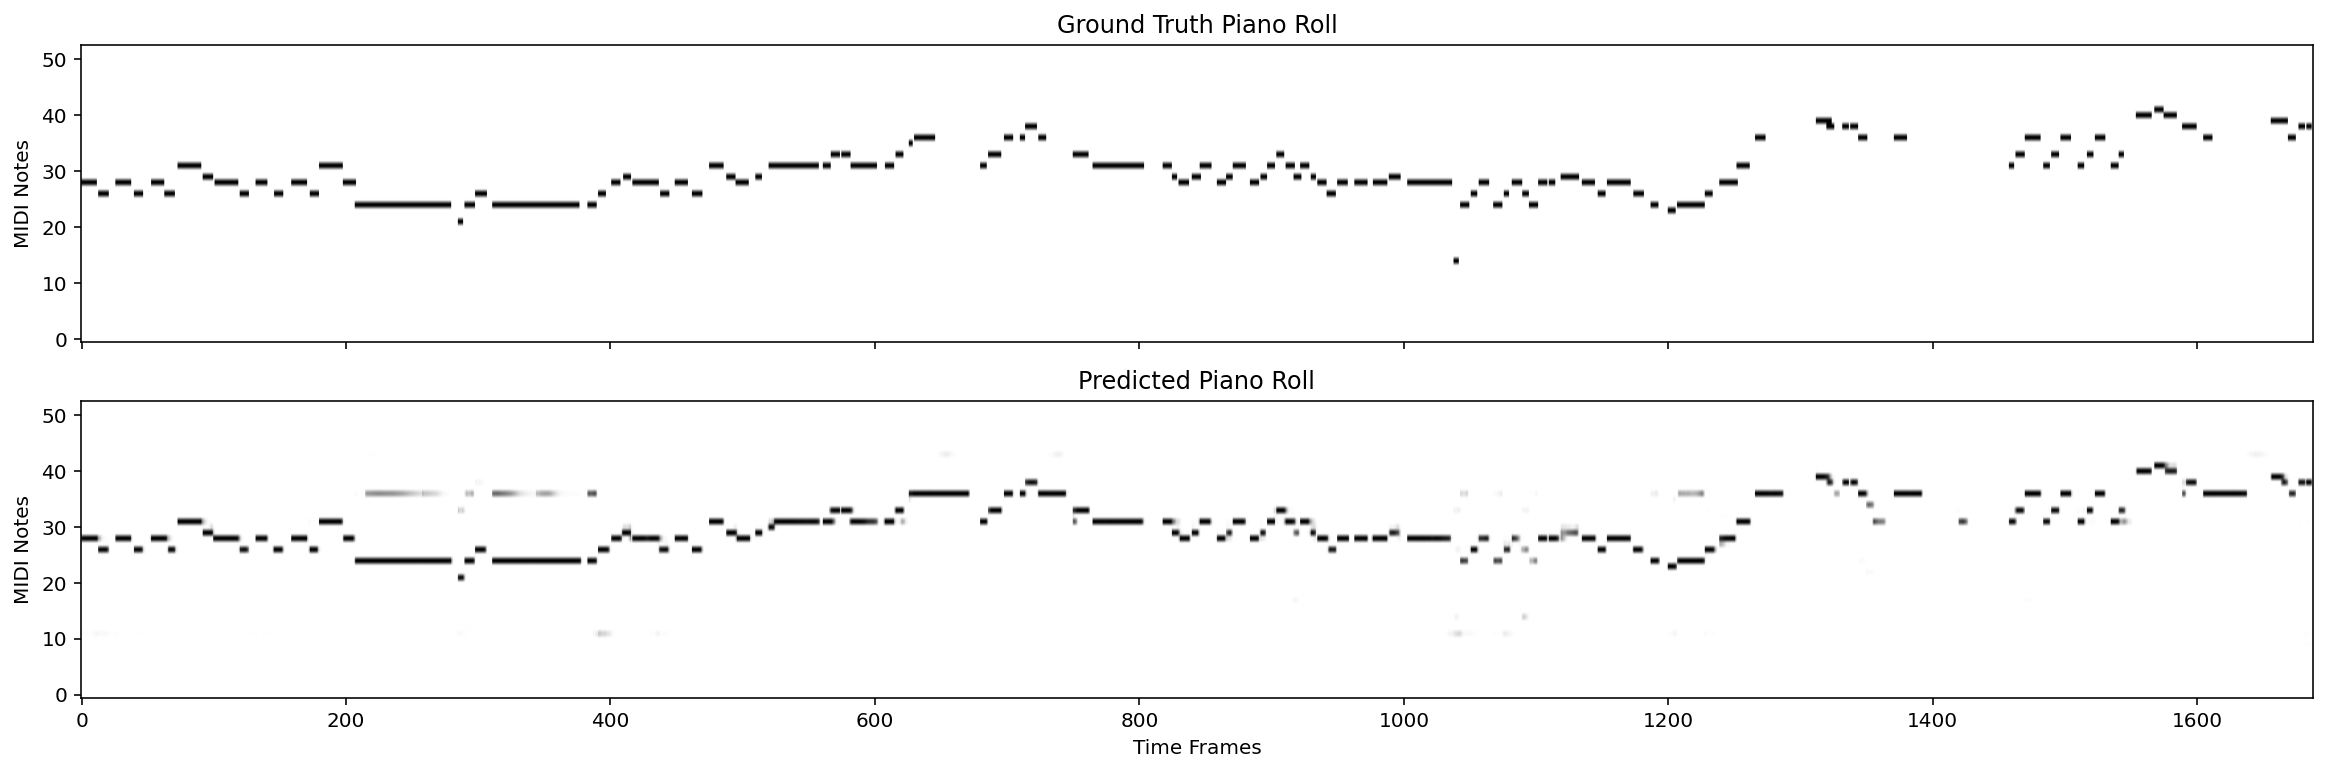

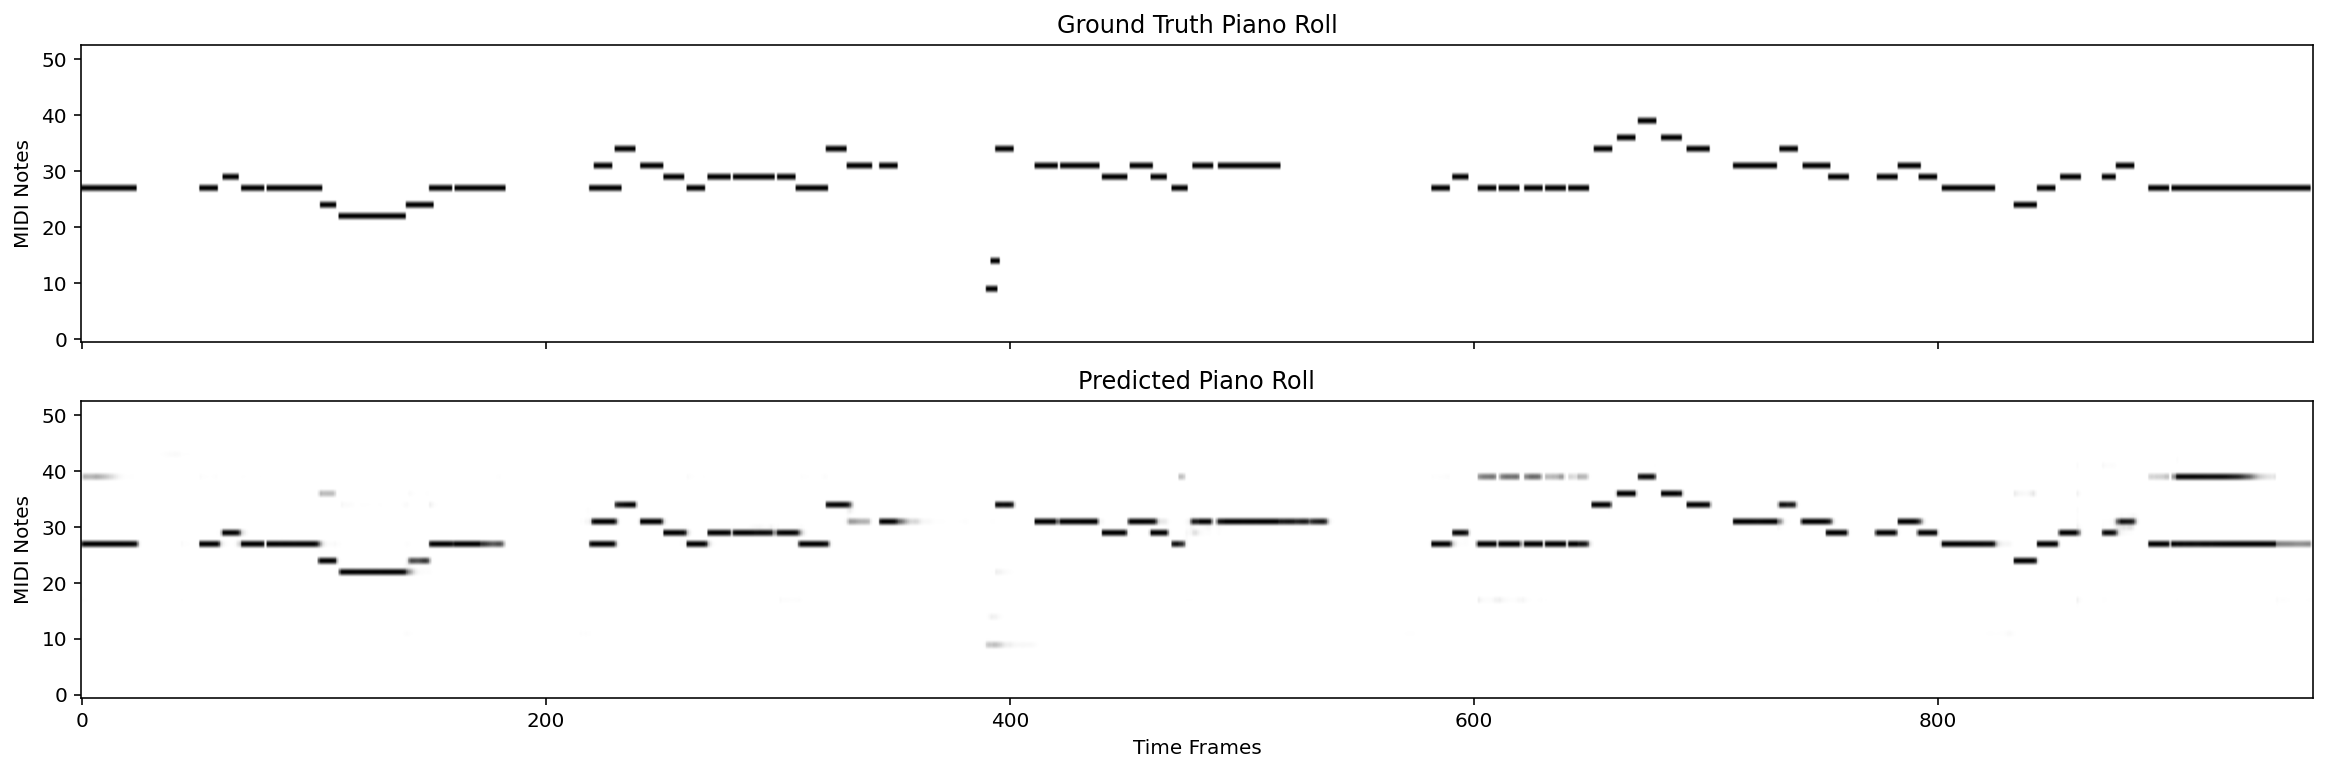

In [69]:
for idx in range(len(predicted_piano_rolls)):
    plot_pianoroll_comparison(predicted_piano_rolls[idx], ground_truth_piano_rolls[idx], apply_sections=False, threshold=None)

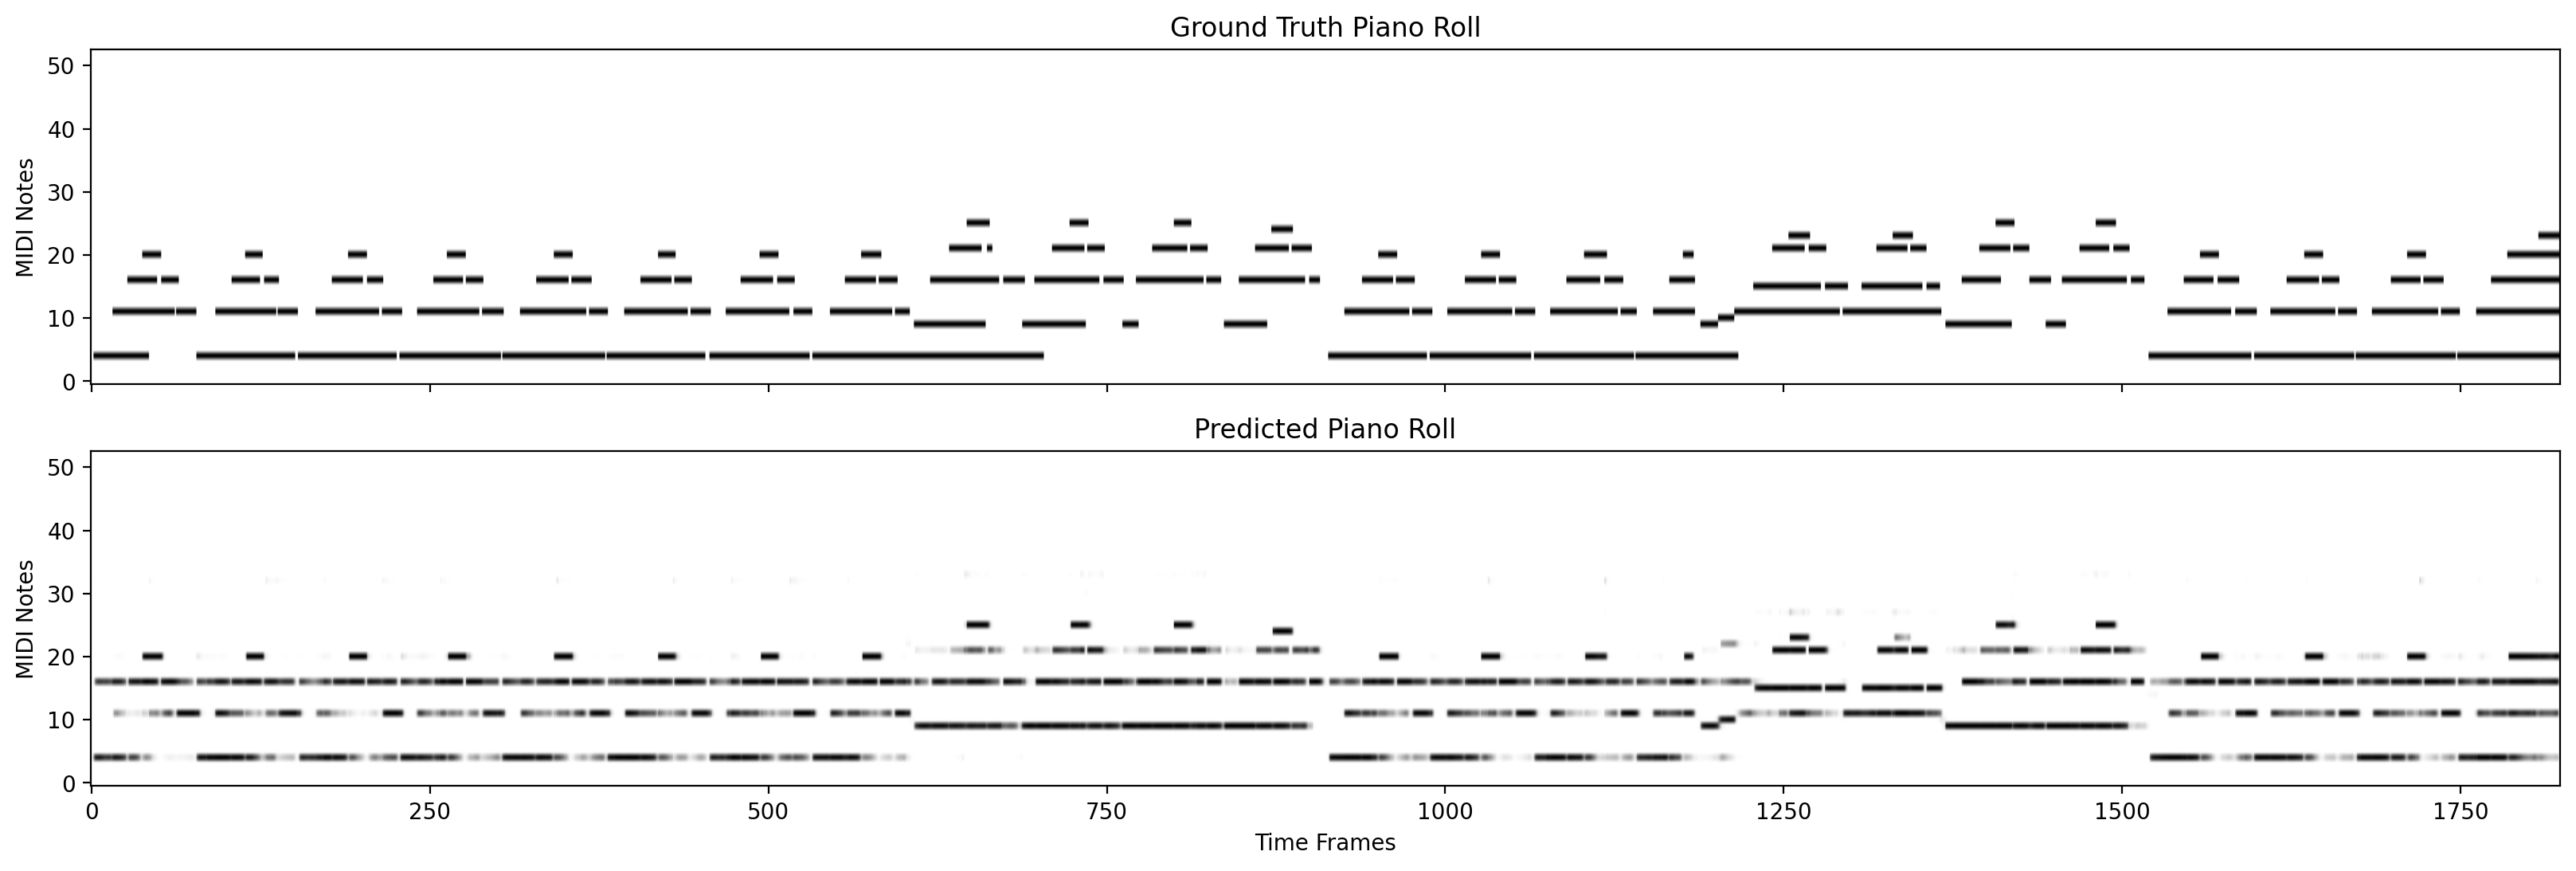

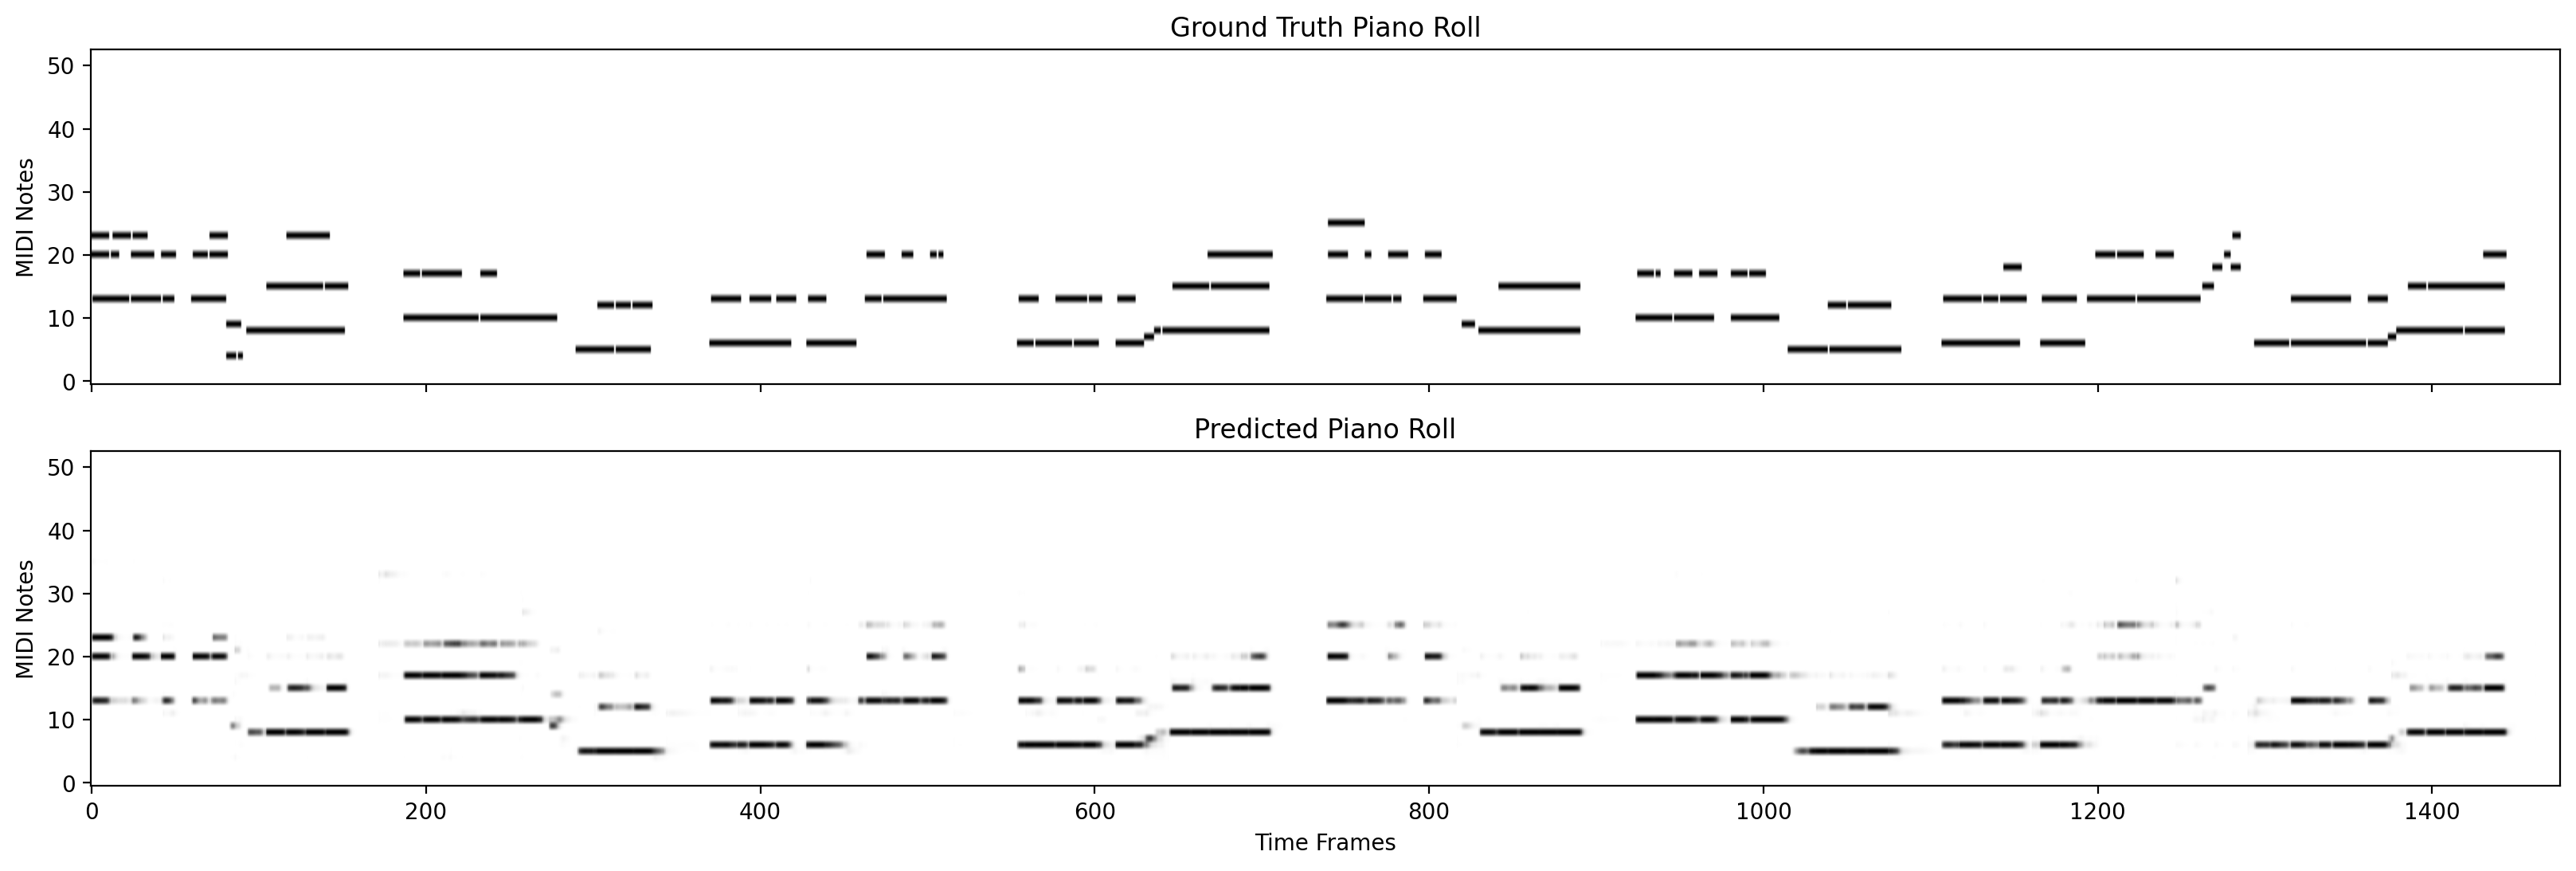

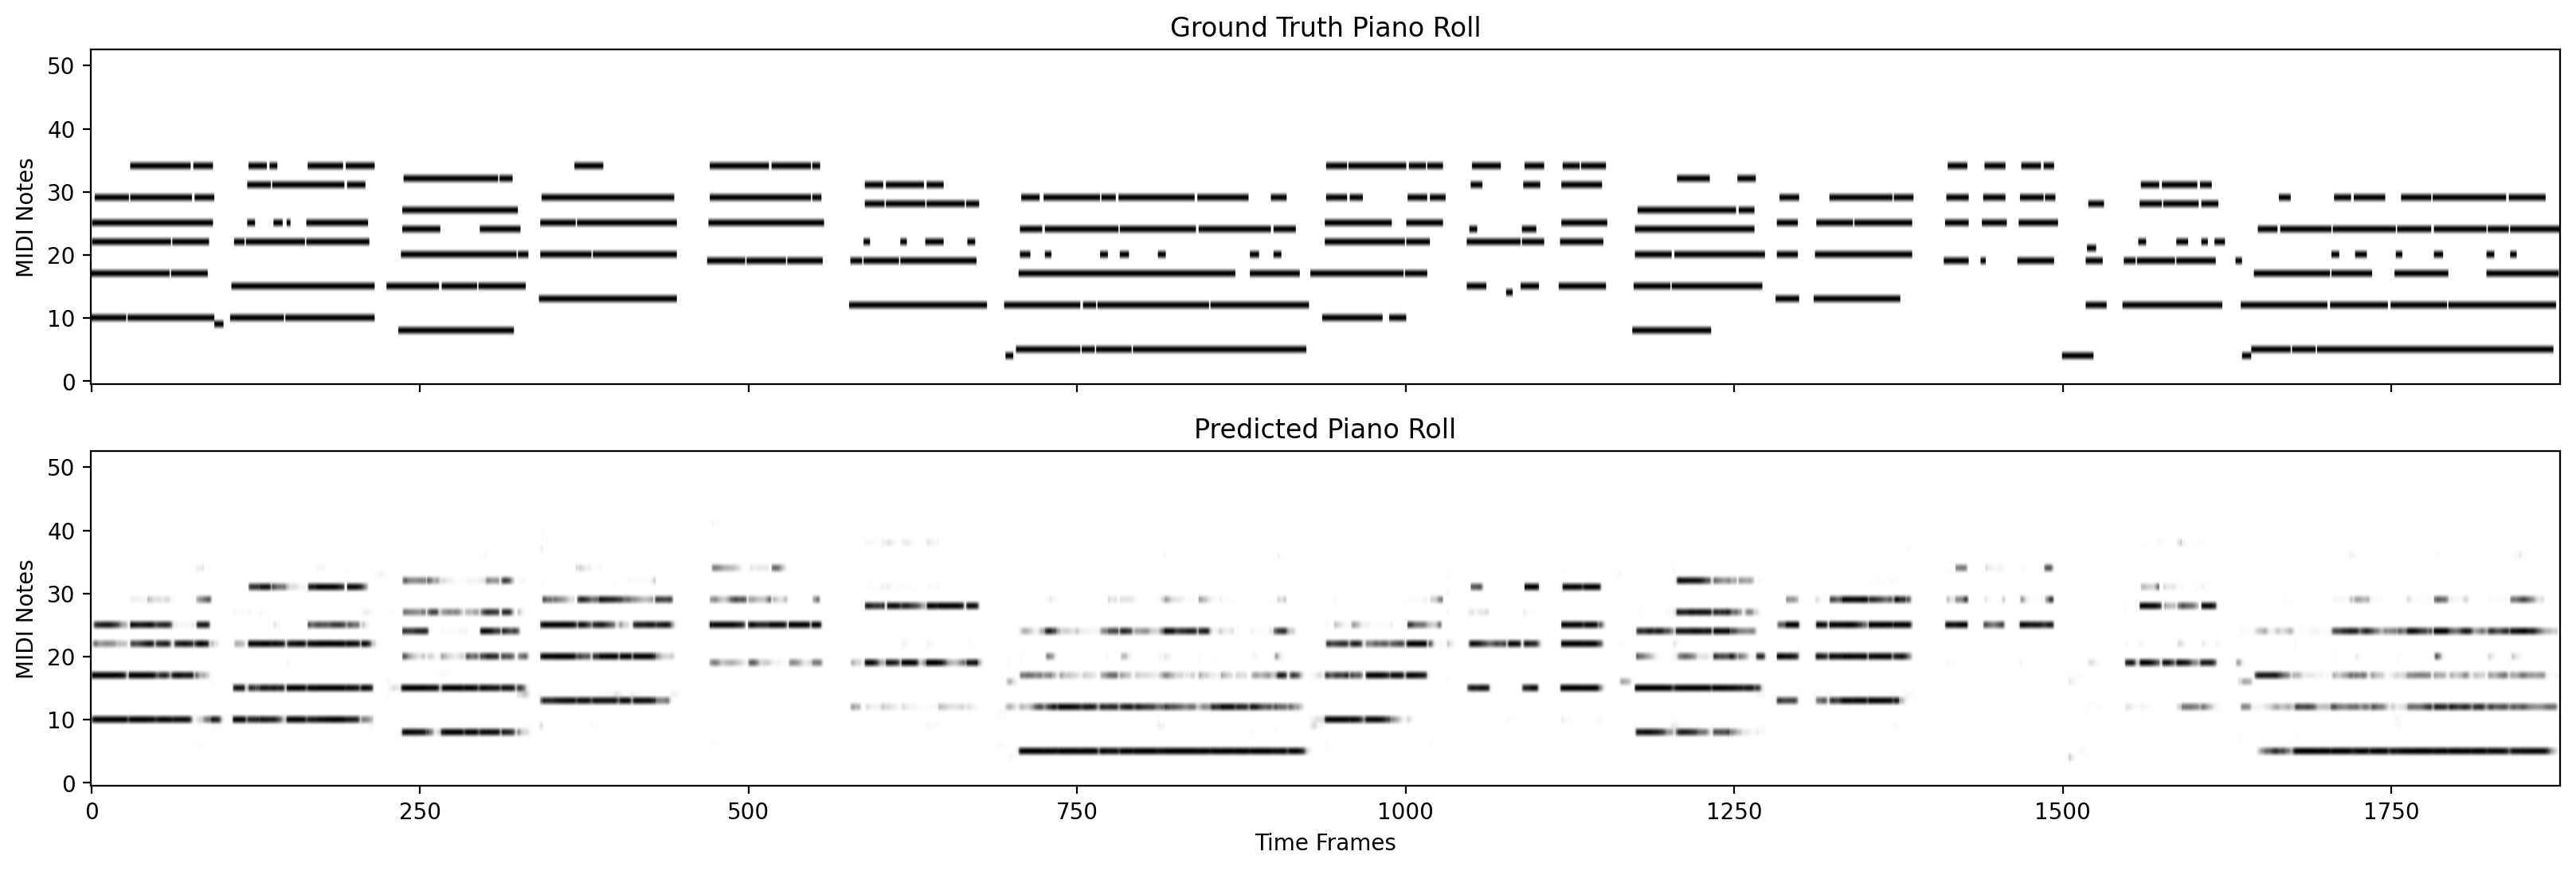

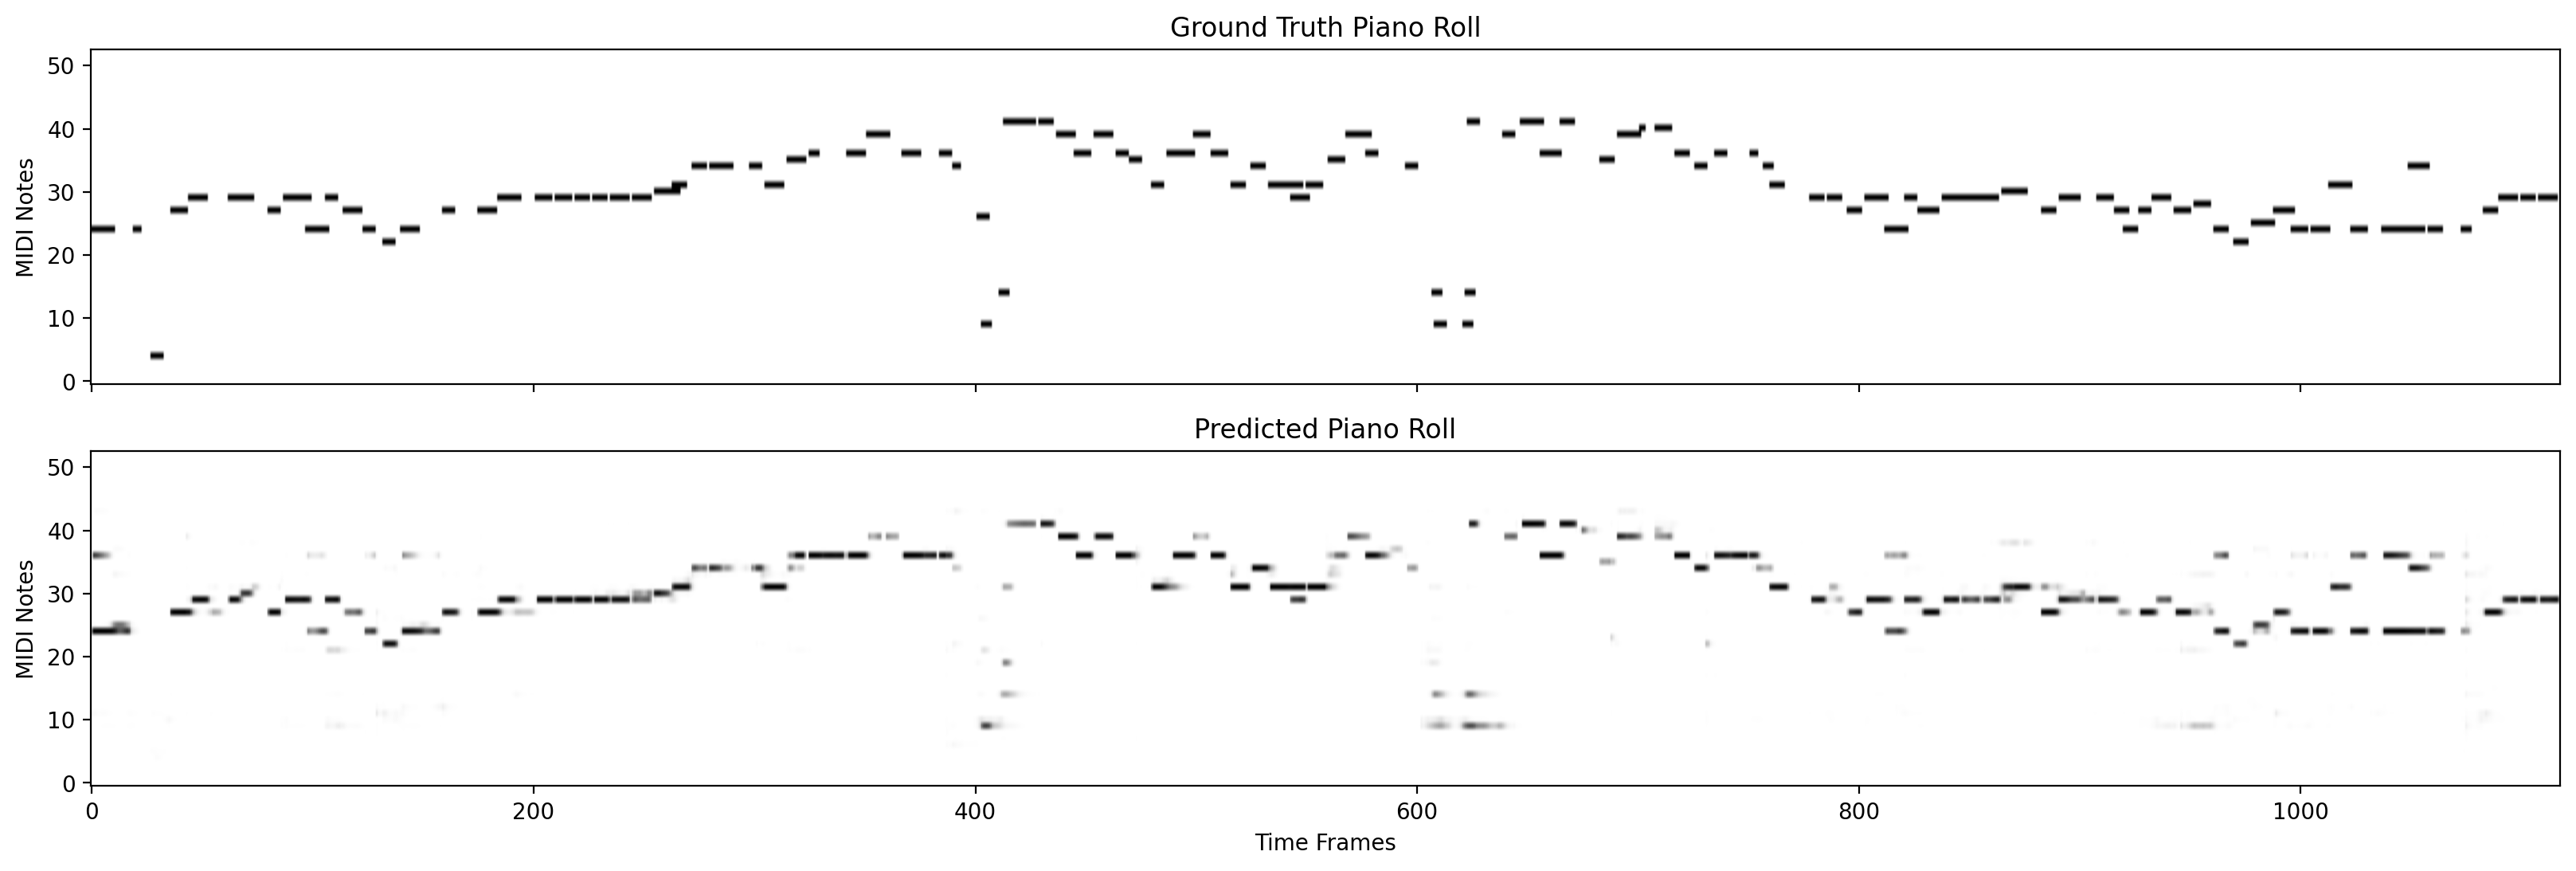

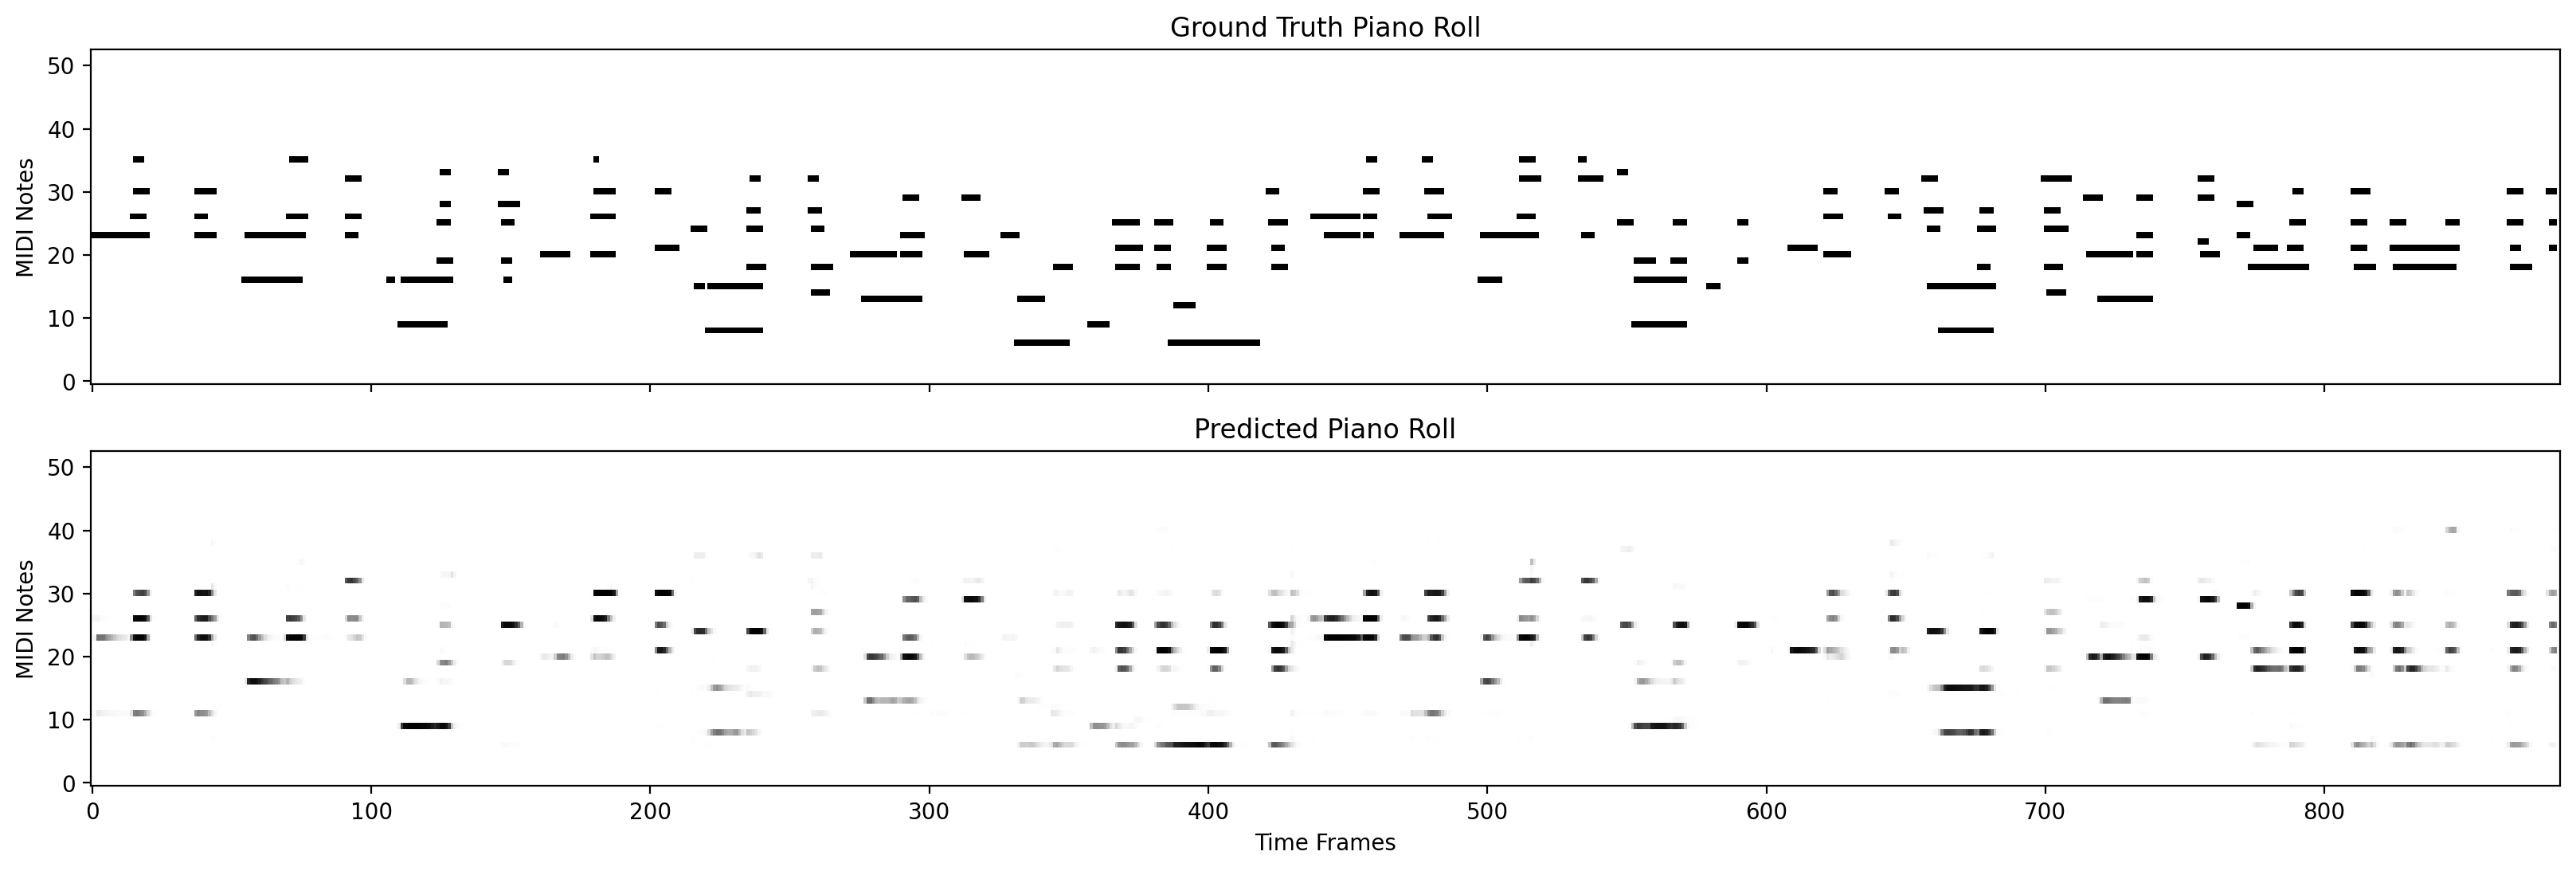

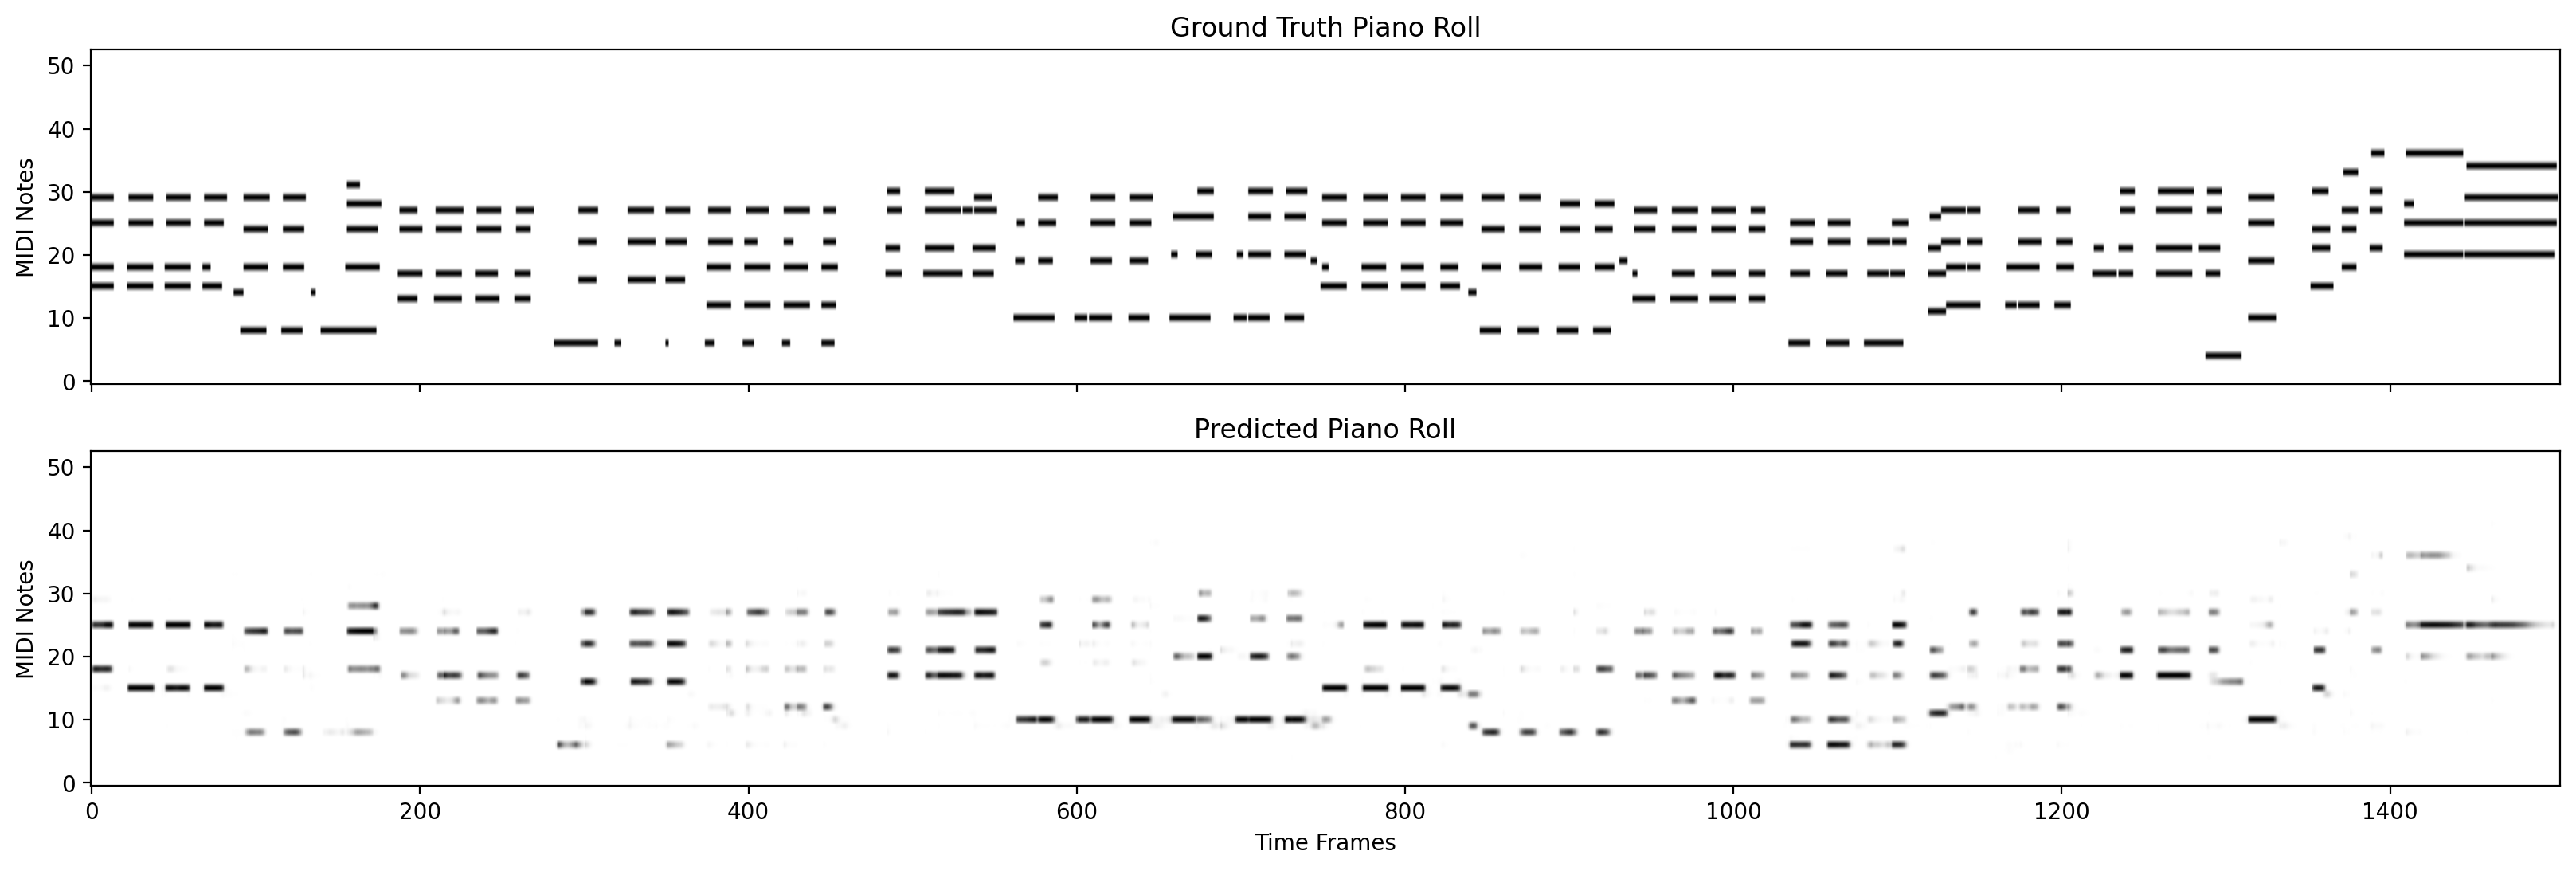

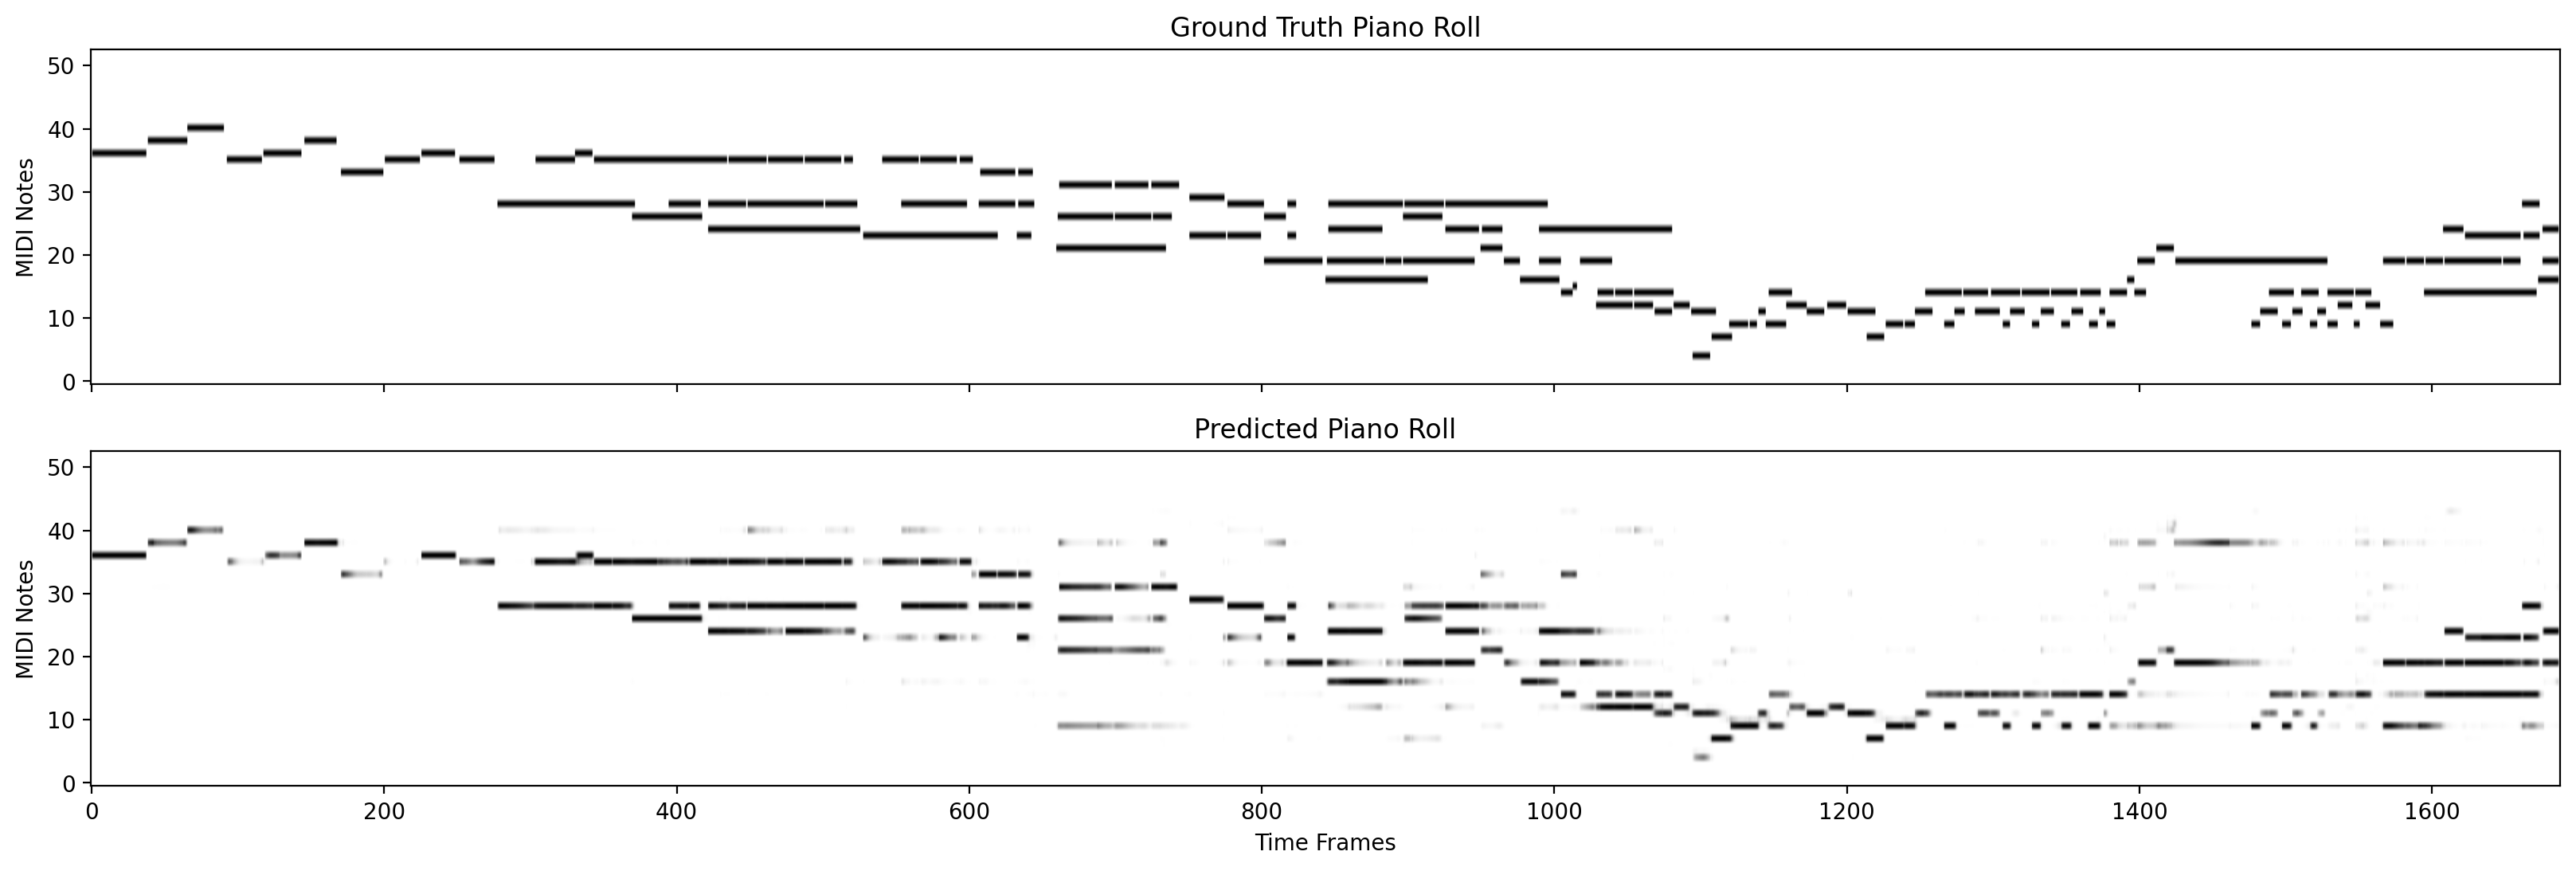

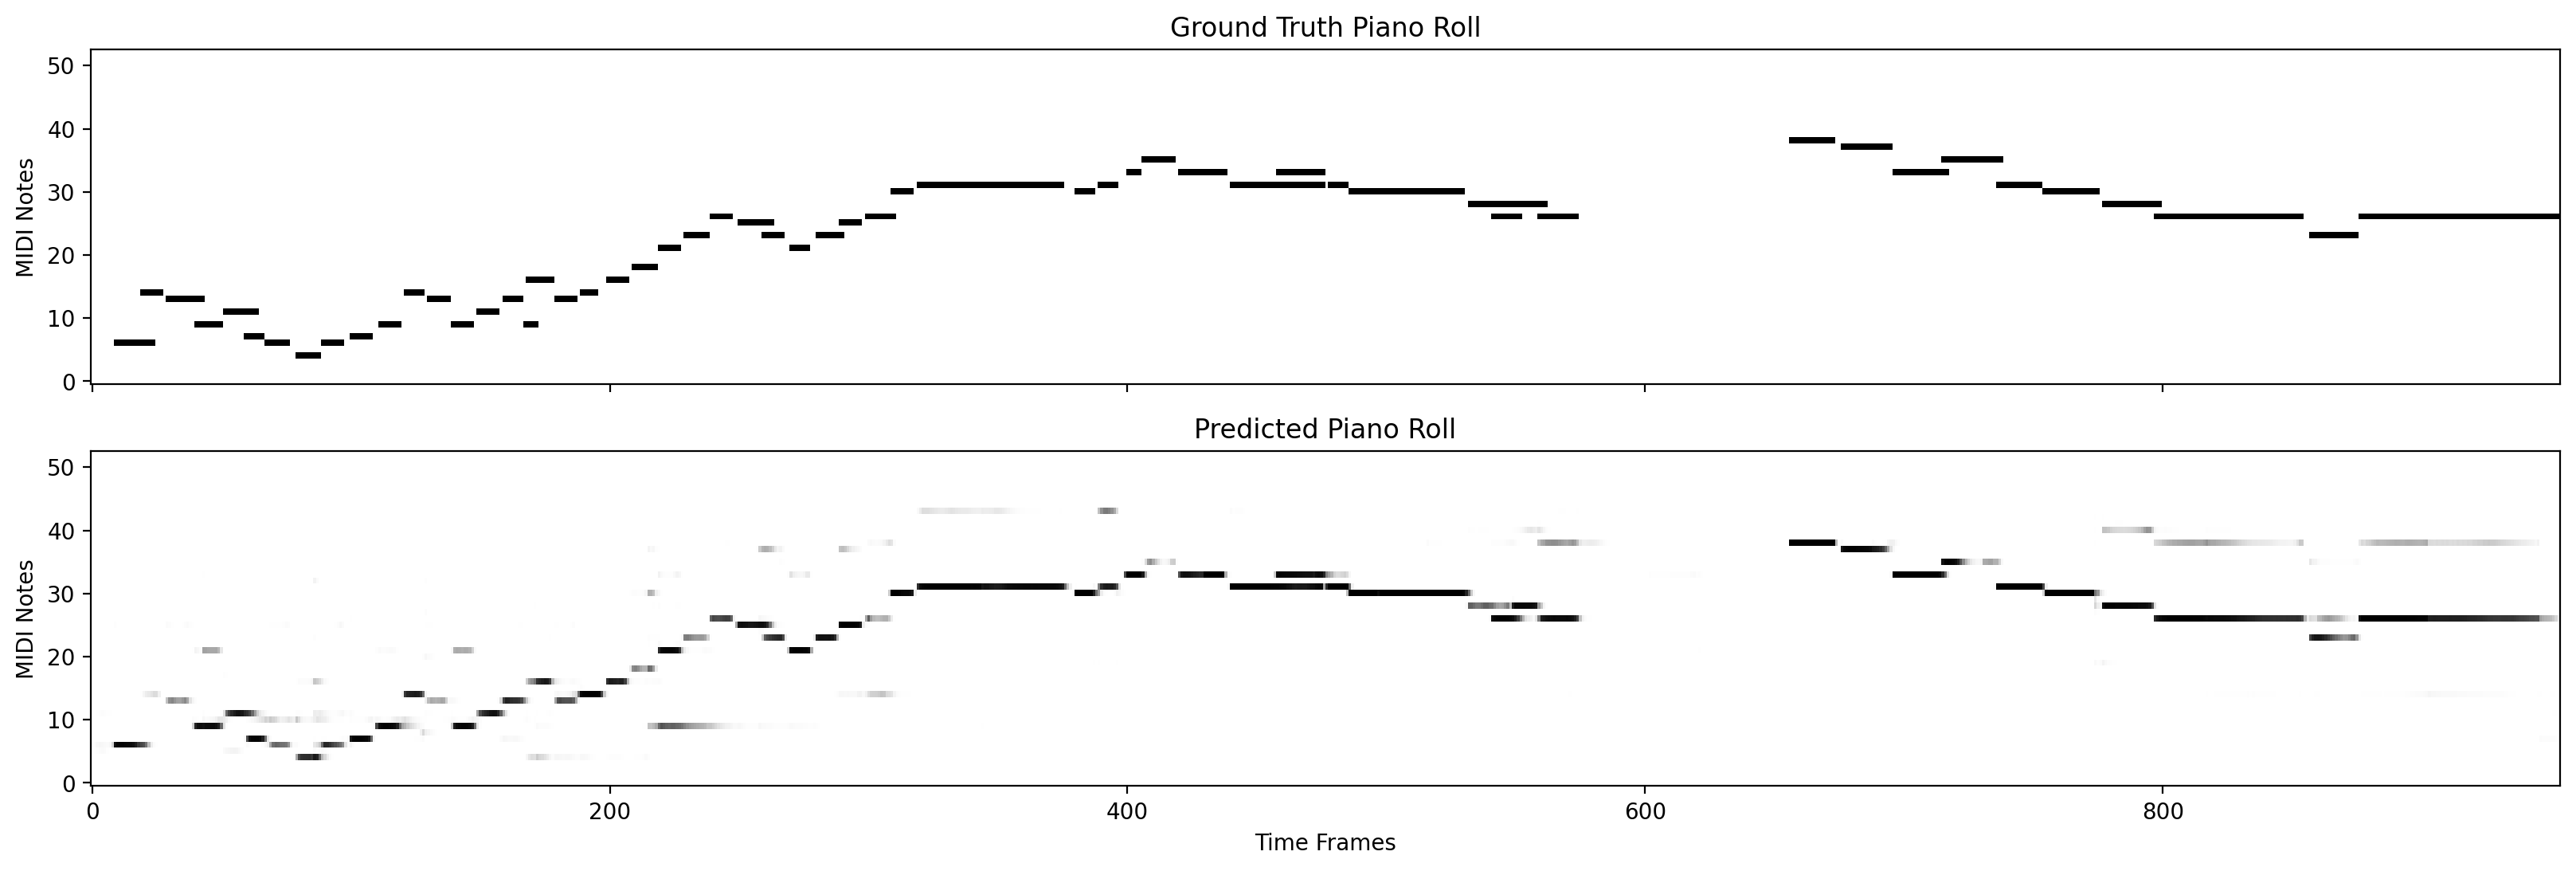

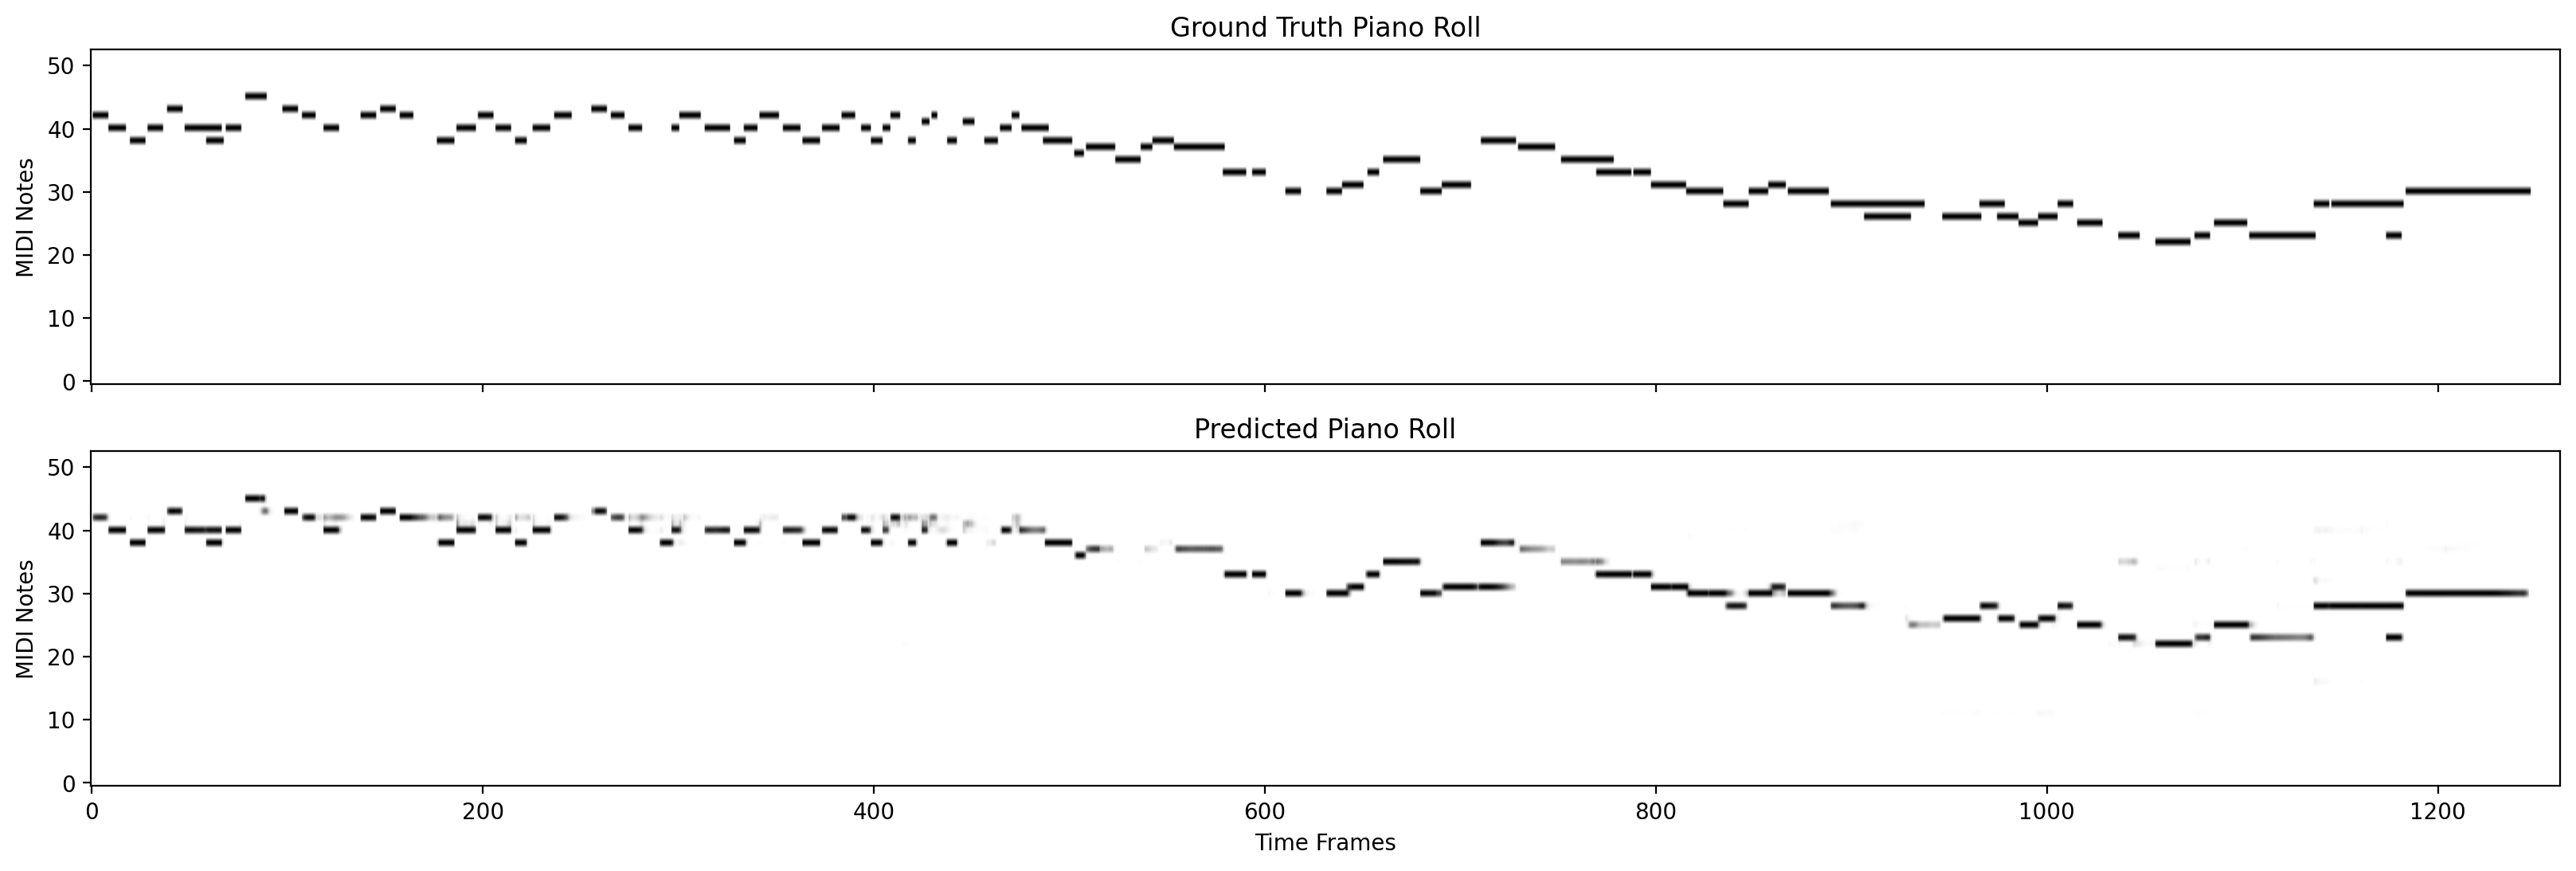

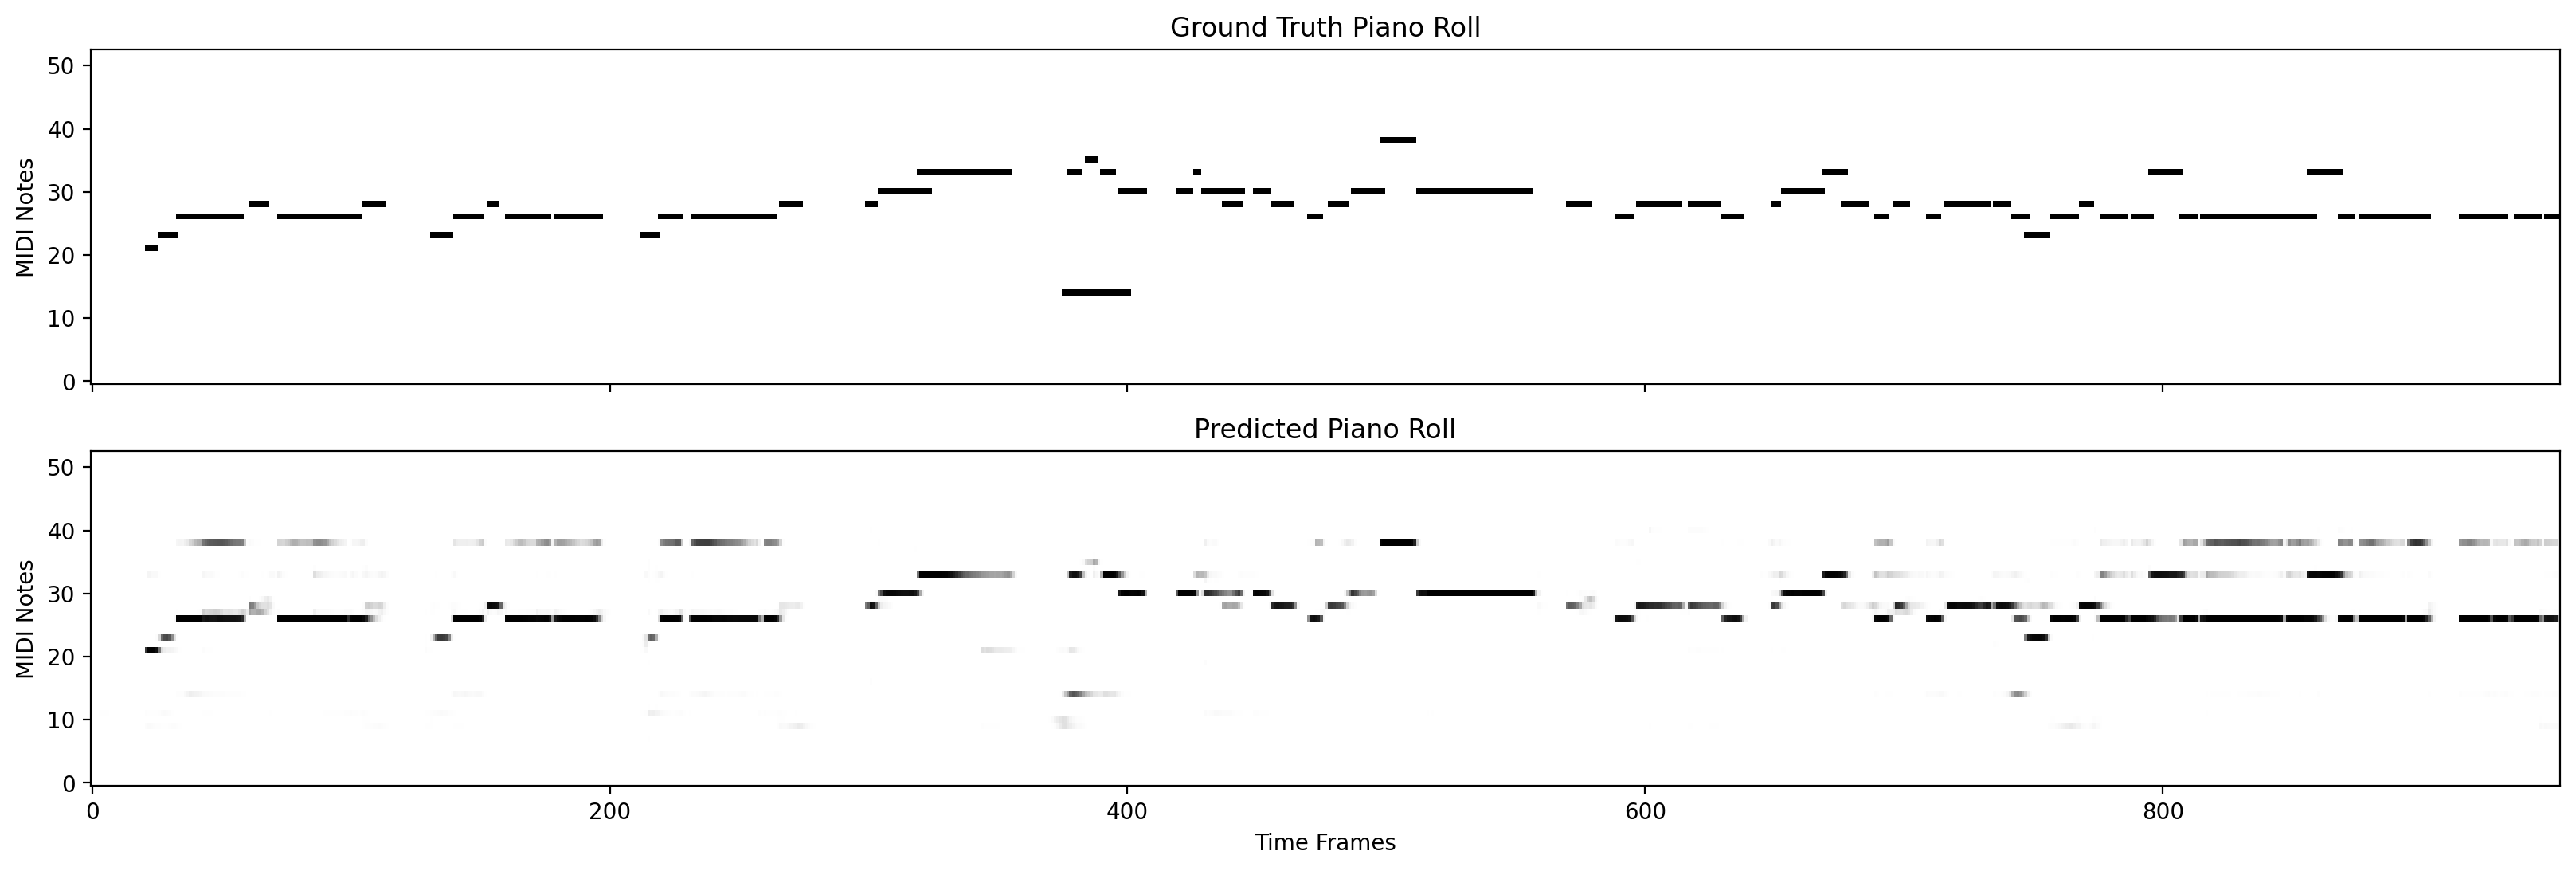

In [46]:
#randomly select 10 samples to visualize
import random

indices = random.sample(range(len(predicted_piano_rolls)), 10)

for idx in indices:
    plot_pianoroll_comparison(predicted_piano_rolls[idx], ground_truth_piano_rolls[idx], apply_sections=False, threshold=None)